In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from mnist_classifier import test_model
from multiple_attacks import *
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VFAE_CONV_NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)

        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 16, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True)
        )

        self.fc_mu = nn.Linear(50, 50)
        self.fc_log_var = nn.Linear(50, 50)

        # Sampling vector
        self.latent = nn.Sequential(

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),

            nn.Linear(50, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(inplace=True)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

        )

    def reparameterize(self, mean, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        z, mu, log_var = self.get_latent(x)
        feature_map_latent = z.view(-1, 16, 7, 7)

        decoded = self.decoder(feature_map_latent)
        output = decoded.view(-1, 1, 28, 28)

        return output, mu, log_var
    
    def get_latent(self, x):
        encoded = self.encoder(x)

        encoded = encoded.view(-1, 7 * 7 * 16)

        fc = self.fc(encoded)

        mu = self.fc_mu(fc)
        log_var = self.fc_log_var(fc)

        z = self.reparameterize(mu, log_var)
        latent = self.latent(z)
        
        return latent, mu, log_var
        
        

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# vae = VAE_FC_NeuralModel()

def VAELoss(x_hat, x, mu, logvar, a, b):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return a*BCE + b*KLD

In [6]:
b_size = 256
def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [7]:
def train_vae(model, train_data,a, b, adv_examples = False):
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    model.to(device)
    if adv_examples is True: 
    # invariant representation training
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output, mean, log_var = model(batch_images)

                latent_1, _, _ = model.get_latent(batch_images.detach())
                latent_2, _, _ = model.get_latent(adv_images.detach())

                down_stream_loss = VAELoss(batch_output, batch_images.detach(), mean, log_var, a, b)
                representation_loss = MMD_Loss(latent_1, latent_2)

                total_loss = .00001*down_stream_loss + 10000*representation_loss


                optimizer.zero_grad()
                total_loss.backward(retain_graph=True)
                optimizer.step()

                print("The classification loss after processing this batch is: ", down_stream_loss.item())
                print("The representation loss after processing this batch is: ", representation_loss.item())

    else:
        ## normal training
        for batch in train_data:
            batch_images, _ = batch
            batch_images = batch_images.to(device)

            batch_output, mean, log_var = model(batch_images)
            loss = VAELoss(batch_output, batch_images, mean, log_var, a, b)

            optimizer.zero_grad()
            loss.backward()
            print("*&**"*30)
            print("the loss after processing this batch is: ", loss.item())
            optimizer.step()

    return model

In [8]:
initial_vae = VFAE_CONV_NeuralModel().to(device)
#initial_vae = train_vae(initial_vae, train_loader, a=1, b=1, False)
#torch.save(initial_vae.state_dict(), "models/trained_vae_b=1_variant_rep")
initial_vae.load_state_dict(torch.load("models/trained_vae_b=1_variant_rep"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

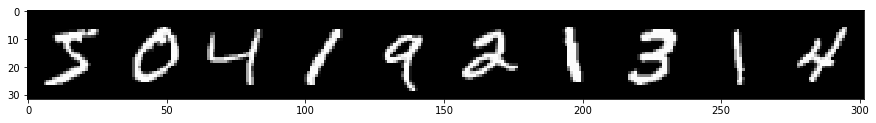

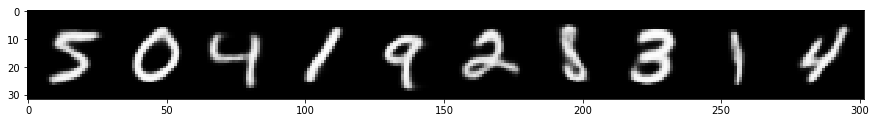

In [9]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
train_loader_iter = iter(train_loader)
first_images, first_labels = next(train_loader_iter)

show_batch(first_images)

recs, _, _ = initial_vae(first_images.to(device))
show_batch(recs.cpu())

In [10]:
class VFAEEClassifier(nn.Module):
    def __init__(self, beta, initial_VAE):
        super().__init__()
        
        self.vae = initial_vae
        
        self.classifier_part = self.encoder = nn.Sequential(

            nn.Conv2d(16, 14, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),

            nn.Conv2d(14, 12, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(12, 10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            
        )
        
        self.fc = nn.Linear(10 * 1 * 1, 10)
        # no_of_last_channels* kernel_H * kernel_W, output_from_fully_conncected 
    def forward(self, x):
        #with torch.no_grad():
        vaee_features, _, _ = self.vae.get_latent(x)

        vaee_features = vaee_features.reshape(-1, 16, 7, 7)
        convolved = self.classifier_part(vaee_features)

        classification_logits = self.fc(convolved.view(convolved.size(0), -1))
        
        return  classification_logits
    

In [11]:
def train_classifier(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for batch in train_data:
            batch_images, batch_labels = batch
            
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            batch_output = model(batch_images)
            loss = criterion(batch_output, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [12]:
b=1

initial_classifier = VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)
model =  VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
model = train_classifier(model, train_loader)

the loss after processing this epoch is:  0.08678028732538223
the loss after processing this epoch is:  0.0888054370880127
the loss after processing this epoch is:  0.09813786298036575
the loss after processing this epoch is:  0.09488239139318466
the loss after processing this epoch is:  0.09651147574186325
the loss after processing this epoch is:  0.09096448868513107
the loss after processing this epoch is:  0.09139630943536758
the loss after processing this epoch is:  0.08351952582597733
the loss after processing this epoch is:  0.08495485037565231
the loss after processing this epoch is:  0.07761388272047043


In [13]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
testing_accuracy_before_attack = test_model(model, test_loader)
print(testing_accuracy_before_attack)

0.9923


In [14]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, train_loader, fgsm, 0.3)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_l2, 1, 0.3, 40)[0])

FGSM Attack : 
0.38766666666666666
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Projected Gradient Attack : 
0.16535
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iFGSM Attack : 
8.333333333333333e-05
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Deep Fool Attack : 
0.11103333333333333


In [15]:
def get_training_examples(model): 
    training_examples = []

    examples = get_examples(model, device, train_loader, fgsm, 0.3)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd, 0.3, 1e4, 40)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)
    training_examples.append(examples)
    
    examples = get_examples(model, device, train_loader, pgd_l2, 1.3, 0.3, 40)

    return training_examples

In [16]:
def train_classifier_adv(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output = model(batch_images)
                loss = criterion(batch_output, batch_labels)
                
                adv_output = model(adv_images)
                
                loss += criterion(adv_output, batch_labels )
                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [17]:
vafee = VFAE_CONV_NeuralModel().to(device)
initial_classifier = VFAEEClassifier(beta=b, initial_VAE=vafee).to(device)

for i in range(5):
    training_examples = get_training_examples(model)
    vafee = train_vae(vafee, training_examples, 1, 1, adv_examples= True)
   
    model =  VFAEEClassifier(beta=1, initial_VAE=vafee).to(device)

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    model = train_classifier_adv(model, training_examples)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([256, 784])) that is different to the input size (torch.Size([256, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  219106.46875
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  185740.765625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  138281.6875
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  109401.296875
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  95115.3828125
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  86211.140625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  75018.234375
The representation loss after processing

The classification loss after processing this batch is:  50711.10546875
The representation loss after processing this batch is:  0.007843108847737312
The classification loss after processing this batch is:  42550.16796875
The representation loss after processing this batch is:  0.007843134924769402
The classification loss after processing this batch is:  43299.93359375
The representation loss after processing this batch is:  0.007843167521059513
The classification loss after processing this batch is:  42610.265625
The representation loss after processing this batch is:  0.00784322526305914
The classification loss after processing this batch is:  45770.05859375
The representation loss after processing this batch is:  0.00784333236515522
The classification loss after processing this batch is:  43584.8984375
The representation loss after processing this batch is:  0.007843157276511192
The classification loss after processing this batch is:  43195.9140625
The representation loss after proc

The classification loss after processing this batch is:  40983.109375
The representation loss after processing this batch is:  0.007843139581382275
The classification loss after processing this batch is:  39350.2421875
The representation loss after processing this batch is:  0.007843166589736938
The classification loss after processing this batch is:  39824.578125
The representation loss after processing this batch is:  0.007843134924769402
The classification loss after processing this batch is:  41327.66015625
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  41977.3046875
The representation loss after processing this batch is:  0.007843143306672573
The classification loss after processing this batch is:  39644.21484375
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  39040.72265625
The representation loss after proces

The classification loss after processing this batch is:  37732.48828125
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  41126.359375
The representation loss after processing this batch is:  0.007843134924769402
The classification loss after processing this batch is:  38619.1640625
The representation loss after processing this batch is:  0.007843139581382275
The classification loss after processing this batch is:  38593.3046875
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  38573.26171875
The representation loss after processing this batch is:  0.0078431386500597
The classification loss after processing this batch is:  40723.296875
The representation loss after processing this batch is:  0.007843133993446827
The classification loss after processing this batch is:  38883.37109375
The representation loss after process

The classification loss after processing this batch is:  35100.453125
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  35115.83984375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  34705.3671875
The representation loss after processing this batch is:  0.007843133062124252
The classification loss after processing this batch is:  38456.703125
The representation loss after processing this batch is:  0.007843139581382275
The classification loss after processing this batch is:  36912.9921875
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  36523.015625
The representation loss after processing this batch is:  0.007843144237995148
The classification loss after processing this batch is:  17584.154296875
The representation loss after process

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([96, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  36327.921875
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  35469.5234375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  35772.94921875
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  34589.6640625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  36153.76953125
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  36818.1875
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  34921.58984375
The representation loss after processi

The classification loss after processing this batch is:  43804.4921875
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  33334.859375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  33961.09375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  32777.5546875
The representation loss after processing this batch is:  0.007843135856091976
The classification loss after processing this batch is:  35964.7265625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  34642.5625
The representation loss after processing this batch is:  0.007843134924769402
The classification loss after processing this batch is:  33580.51953125
The representation loss after processing

The classification loss after processing this batch is:  33820.0390625
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  33356.8828125
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  34838.51953125
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  35289.1171875
The representation loss after processing this batch is:  0.007843133993446827
The classification loss after processing this batch is:  35265.71484375
The representation loss after processing this batch is:  0.007843133993446827
The classification loss after processing this batch is:  33341.08203125
The representation loss after processing this batch is:  0.00784313678741455
The classification loss after processing this batch is:  33517.19140625
The representation loss after pro

The classification loss after processing this batch is:  32321.55078125
The representation loss after processing this batch is:  0.007843135856091976
The classification loss after processing this batch is:  34337.234375
The representation loss after processing this batch is:  0.007843149825930595
The classification loss after processing this batch is:  31733.623046875
The representation loss after processing this batch is:  0.00784311443567276
The classification loss after processing this batch is:  32953.2578125
The representation loss after processing this batch is:  0.007843165658414364
The classification loss after processing this batch is:  32733.65625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  34354.2578125
The representation loss after processing this batch is:  0.007843135856091976
The classification loss after processing this batch is:  32750.6484375
The representation loss after proces

The classification loss after processing this batch is:  31923.37109375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  31965.923828125
The representation loss after processing this batch is:  0.007843093015253544
The classification loss after processing this batch is:  31263.62890625
The representation loss after processing this batch is:  0.007843143306672573
The classification loss after processing this batch is:  33880.15234375
The representation loss after processing this batch is:  0.007843142375349998
The classification loss after processing this batch is:  33111.5390625
The representation loss after processing this batch is:  0.007843135856091976
The classification loss after processing this batch is:  32870.3359375
The representation loss after processing this batch is:  0.0078431386500597
The classification loss after processing this batch is:  16998.072265625
The representation loss after 

The classification loss after processing this batch is:  161132.96875
The representation loss after processing this batch is:  0.00027091242372989655
The classification loss after processing this batch is:  160112.0625
The representation loss after processing this batch is:  0.00023331120610237122
The classification loss after processing this batch is:  157174.90625
The representation loss after processing this batch is:  0.00022364407777786255
The classification loss after processing this batch is:  157562.28125
The representation loss after processing this batch is:  0.00022716447710990906
The classification loss after processing this batch is:  154629.1875
The representation loss after processing this batch is:  0.00021237879991531372
The classification loss after processing this batch is:  151150.234375
The representation loss after processing this batch is:  0.00023238733410835266
The classification loss after processing this batch is:  153372.65625
The representation loss after p

The classification loss after processing this batch is:  103555.0234375
The representation loss after processing this batch is:  0.00018604658544063568
The classification loss after processing this batch is:  107767.640625
The representation loss after processing this batch is:  0.00020878203213214874
The classification loss after processing this batch is:  103490.984375
The representation loss after processing this batch is:  0.00018051639199256897
The classification loss after processing this batch is:  103659.4296875
The representation loss after processing this batch is:  0.00016970373690128326
The classification loss after processing this batch is:  101669.5234375
The representation loss after processing this batch is:  0.0002095382660627365
The classification loss after processing this batch is:  102698.6328125
The representation loss after processing this batch is:  0.00019606761634349823
The classification loss after processing this batch is:  102111.65625
The representation lo

The classification loss after processing this batch is:  85286.390625
The representation loss after processing this batch is:  0.00016016885638237
The classification loss after processing this batch is:  85027.1796875
The representation loss after processing this batch is:  0.00016565993428230286
The classification loss after processing this batch is:  85679.0
The representation loss after processing this batch is:  0.00017782114446163177
The classification loss after processing this batch is:  88971.1875
The representation loss after processing this batch is:  0.00016874074935913086
The classification loss after processing this batch is:  89090.09375
The representation loss after processing this batch is:  0.00017203204333782196
The classification loss after processing this batch is:  85081.703125
The representation loss after processing this batch is:  0.0001767631620168686
The classification loss after processing this batch is:  84147.078125
The representation loss after processing 

The classification loss after processing this batch is:  77593.875
The representation loss after processing this batch is:  0.0001591108739376068
The classification loss after processing this batch is:  78160.0
The representation loss after processing this batch is:  0.00017501041293144226
The classification loss after processing this batch is:  79397.1796875
The representation loss after processing this batch is:  0.000155523419380188
The classification loss after processing this batch is:  75446.359375
The representation loss after processing this batch is:  0.00017605535686016083
The classification loss after processing this batch is:  79200.40625
The representation loss after processing this batch is:  0.00017067231237888336
The classification loss after processing this batch is:  80143.421875
The representation loss after processing this batch is:  0.00016974471509456635
The classification loss after processing this batch is:  75815.84375
The representation loss after processing t

The classification loss after processing this batch is:  73794.453125
The representation loss after processing this batch is:  6.963592022657394e-05
The classification loss after processing this batch is:  73168.015625
The representation loss after processing this batch is:  7.120799273252487e-05
The classification loss after processing this batch is:  72040.9375
The representation loss after processing this batch is:  6.965454667806625e-05
The classification loss after processing this batch is:  73113.2421875
The representation loss after processing this batch is:  7.485691457986832e-05
The classification loss after processing this batch is:  72602.9765625
The representation loss after processing this batch is:  7.242430001497269e-05
The classification loss after processing this batch is:  74013.15625
The representation loss after processing this batch is:  7.190648466348648e-05
The classification loss after processing this batch is:  76186.3125
The representation loss after processin

The classification loss after processing this batch is:  69951.125
The representation loss after processing this batch is:  7.221661508083344e-05
The classification loss after processing this batch is:  67487.421875
The representation loss after processing this batch is:  7.100775837898254e-05
The classification loss after processing this batch is:  67867.8125
The representation loss after processing this batch is:  7.600151002407074e-05
The classification loss after processing this batch is:  66387.5
The representation loss after processing this batch is:  7.057469338178635e-05
The classification loss after processing this batch is:  68346.96875
The representation loss after processing this batch is:  8.36588442325592e-05
The classification loss after processing this batch is:  68040.765625
The representation loss after processing this batch is:  7.876008749008179e-05
The classification loss after processing this batch is:  67744.765625
The representation loss after processing this ba

The classification loss after processing this batch is:  63098.1875
The representation loss after processing this batch is:  7.057376205921173e-05
The classification loss after processing this batch is:  64271.4765625
The representation loss after processing this batch is:  6.86226412653923e-05
The classification loss after processing this batch is:  65045.359375
The representation loss after processing this batch is:  6.656721234321594e-05
The classification loss after processing this batch is:  62707.3984375
The representation loss after processing this batch is:  7.009971886873245e-05
The classification loss after processing this batch is:  64410.5703125
The representation loss after processing this batch is:  6.69434666633606e-05
The classification loss after processing this batch is:  66911.046875
The representation loss after processing this batch is:  6.81169331073761e-05
The classification loss after processing this batch is:  62483.640625
The representation loss after processi

The classification loss after processing this batch is:  59155.14453125
The representation loss after processing this batch is:  6.170570850372314e-05
The classification loss after processing this batch is:  61406.9921875
The representation loss after processing this batch is:  6.705895066261292e-05
The classification loss after processing this batch is:  58310.1015625
The representation loss after processing this batch is:  7.006805390119553e-05
The classification loss after processing this batch is:  58192.625
The representation loss after processing this batch is:  6.77984207868576e-05
The classification loss after processing this batch is:  60038.53515625
The representation loss after processing this batch is:  6.755813956260681e-05
The classification loss after processing this batch is:  58823.859375
The representation loss after processing this batch is:  6.986036896705627e-05
The classification loss after processing this batch is:  59044.6328125
The representation loss after pro

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  29557.9296875
The representation loss after processing this batch is:  0.0006529917009174824
The classification loss after processing this batch is:  30029.6640625
The representation loss after processing this batch is:  0.0004587369039654732
The classification loss after processing this batch is:  28700.19921875
The representation loss after processing this batch is:  0.0005044876597821712
The classification loss after processing this batch is:  29762.185546875
The representation loss after processing this batch is:  0.00041428767144680023
The classification loss after processing this batch is:  31402.455078125
The representation loss after processing this batch is:  0.0004945327527821064
The classification loss after processing this batch is:  31519.90234375
The representation loss after processing this batch is:  0.000363299623131752
The classification loss after processing this batch is:  31507.107421875
The representation lo

The classification loss after processing this batch is:  31946.39453125
The representation loss after processing this batch is:  0.00018418394029140472
The classification loss after processing this batch is:  33366.078125
The representation loss after processing this batch is:  0.00015495624393224716
The classification loss after processing this batch is:  32492.912109375
The representation loss after processing this batch is:  0.00013692863285541534
The classification loss after processing this batch is:  30312.935546875
The representation loss after processing this batch is:  0.0001552775502204895
The classification loss after processing this batch is:  31085.63671875
The representation loss after processing this batch is:  0.00016319192945957184
The classification loss after processing this batch is:  30929.7421875
The representation loss after processing this batch is:  0.00013973936438560486
The classification loss after processing this batch is:  31975.994140625
The representatio

The classification loss after processing this batch is:  30024.47265625
The representation loss after processing this batch is:  0.0001408196985721588
The classification loss after processing this batch is:  29521.6875
The representation loss after processing this batch is:  0.0001398082822561264
The classification loss after processing this batch is:  30483.78125
The representation loss after processing this batch is:  0.00013331416994333267
The classification loss after processing this batch is:  30958.04296875
The representation loss after processing this batch is:  0.0001642182469367981
The classification loss after processing this batch is:  28851.4140625
The representation loss after processing this batch is:  0.00015493668615818024
The classification loss after processing this batch is:  29625.2890625
The representation loss after processing this batch is:  0.0001511741429567337
The classification loss after processing this batch is:  28839.29296875
The representation loss after

The classification loss after processing this batch is:  30049.98828125
The representation loss after processing this batch is:  0.0001404210925102234
The classification loss after processing this batch is:  28426.41796875
The representation loss after processing this batch is:  0.00013721920549869537
The classification loss after processing this batch is:  29662.64453125
The representation loss after processing this batch is:  0.00016104988753795624
The classification loss after processing this batch is:  29308.634765625
The representation loss after processing this batch is:  0.00015440769493579865
The classification loss after processing this batch is:  29883.845703125
The representation loss after processing this batch is:  0.00015140697360038757
The classification loss after processing this batch is:  30579.9921875
The representation loss after processing this batch is:  0.00013405457139015198
The classification loss after processing this batch is:  30553.732421875
The representat

The classification loss after processing this batch is:  27981.361328125
The representation loss after processing this batch is:  0.0001258552074432373
The classification loss after processing this batch is:  28297.904296875
The representation loss after processing this batch is:  0.00018123909831047058
The classification loss after processing this batch is:  28259.353515625
The representation loss after processing this batch is:  0.00016522593796253204
The classification loss after processing this batch is:  28665.3203125
The representation loss after processing this batch is:  0.000137966126203537
The classification loss after processing this batch is:  29454.83203125
The representation loss after processing this batch is:  0.0001443270593881607
The classification loss after processing this batch is:  28267.78515625
The representation loss after processing this batch is:  0.00012027472257614136
The classification loss after processing this batch is:  27822.4375
The representation los

The classification loss after processing this batch is:  27523.91015625
The representation loss after processing this batch is:  0.00014930590987205505
The classification loss after processing this batch is:  29329.3671875
The representation loss after processing this batch is:  0.00012329407036304474
The classification loss after processing this batch is:  27857.203125
The representation loss after processing this batch is:  0.00014020316302776337
The classification loss after processing this batch is:  28620.953125
The representation loss after processing this batch is:  0.0001337137073278427
The classification loss after processing this batch is:  27606.18359375
The representation loss after processing this batch is:  0.00014461949467658997
The classification loss after processing this batch is:  28100.919921875
The representation loss after processing this batch is:  0.00014852546155452728
The classification loss after processing this batch is:  27298.990234375
The representation l

The classification loss after processing this batch is:  28000.765625
The representation loss after processing this batch is:  0.00017409026622772217
The classification loss after processing this batch is:  29095.078125
The representation loss after processing this batch is:  0.00012858398258686066
The classification loss after processing this batch is:  29356.4921875
The representation loss after processing this batch is:  0.0001212097704410553
The classification loss after processing this batch is:  27925.4140625
The representation loss after processing this batch is:  0.0001384355127811432
The classification loss after processing this batch is:  29118.009765625
The representation loss after processing this batch is:  0.00012758001685142517
The classification loss after processing this batch is:  28460.25
The representation loss after processing this batch is:  0.0001417640596628189
The classification loss after processing this batch is:  27773.5390625
The representation loss after p

The classification loss after processing this batch is:  26918.8046875
The representation loss after processing this batch is:  0.00014601461589336395
The classification loss after processing this batch is:  29626.25390625
The representation loss after processing this batch is:  0.00013767648488283157
The classification loss after processing this batch is:  27720.13671875
The representation loss after processing this batch is:  0.00011343881487846375
The classification loss after processing this batch is:  27082.86328125
The representation loss after processing this batch is:  0.00014109443873167038
The classification loss after processing this batch is:  27914.783203125
The representation loss after processing this batch is:  0.00014569144695997238
The classification loss after processing this batch is:  28500.125
The representation loss after processing this batch is:  0.0001430027186870575
The classification loss after processing this batch is:  27736.501953125
The representation lo

The classification loss after processing this batch is:  28321.056640625
The representation loss after processing this batch is:  0.00014263764023780823
The classification loss after processing this batch is:  28661.017578125
The representation loss after processing this batch is:  0.0001393388956785202
The classification loss after processing this batch is:  28193.412109375
The representation loss after processing this batch is:  0.00013585202395915985
The classification loss after processing this batch is:  27994.318359375
The representation loss after processing this batch is:  0.00014787539839744568
The classification loss after processing this batch is:  27898.74609375
The representation loss after processing this batch is:  0.00013992004096508026
The classification loss after processing this batch is:  27294.314453125
The representation loss after processing this batch is:  0.00013406574726104736
The classification loss after processing this batch is:  28740.30078125
The represen

The classification loss after processing this batch is:  28011.86328125
The representation loss after processing this batch is:  0.00016632117331027985
The classification loss after processing this batch is:  26664.85546875
The representation loss after processing this batch is:  0.00014430657029151917
The classification loss after processing this batch is:  29070.359375
The representation loss after processing this batch is:  0.0001462157815694809
The classification loss after processing this batch is:  29044.587890625
The representation loss after processing this batch is:  0.00013233907520771027
The classification loss after processing this batch is:  29404.0234375
The representation loss after processing this batch is:  0.00014921091496944427
The classification loss after processing this batch is:  28263.73046875
The representation loss after processing this batch is:  0.00013422593474388123
The classification loss after processing this batch is:  27896.095703125
The representation

The classification loss after processing this batch is:  29440.6796875
The representation loss after processing this batch is:  0.00013716146349906921
The classification loss after processing this batch is:  27316.958984375
The representation loss after processing this batch is:  0.00016581080853939056
The classification loss after processing this batch is:  27237.28515625
The representation loss after processing this batch is:  0.00013258680701255798
The classification loss after processing this batch is:  28854.171875
The representation loss after processing this batch is:  0.00015360116958618164
The classification loss after processing this batch is:  28223.92578125
The representation loss after processing this batch is:  0.00013762153685092926
The classification loss after processing this batch is:  27433.69140625
The representation loss after processing this batch is:  0.00014822930097579956
The classification loss after processing this batch is:  28845.078125
The representation l

The classification loss after processing this batch is:  28435.2421875
The representation loss after processing this batch is:  0.0001276303082704544
The classification loss after processing this batch is:  27705.509765625
The representation loss after processing this batch is:  0.00013573560863733292
The classification loss after processing this batch is:  26635.419921875
The representation loss after processing this batch is:  0.00015486963093280792
The classification loss after processing this batch is:  25590.484375
The representation loss after processing this batch is:  0.00015526451170444489
The classification loss after processing this batch is:  25673.4140625
The representation loss after processing this batch is:  0.00012945756316184998
The classification loss after processing this batch is:  27331.2421875
The representation loss after processing this batch is:  0.00013496167957782745
The classification loss after processing this batch is:  28359.5546875
The representation lo

The classification loss after processing this batch is:  27842.677734375
The representation loss after processing this batch is:  0.0001373235136270523
The classification loss after processing this batch is:  29452.7734375
The representation loss after processing this batch is:  0.00013915449380874634
The classification loss after processing this batch is:  27782.556640625
The representation loss after processing this batch is:  0.00013648904860019684
The classification loss after processing this batch is:  28841.216796875
The representation loss after processing this batch is:  0.00013392604887485504
The classification loss after processing this batch is:  27290.41796875
The representation loss after processing this batch is:  0.0001408848911523819
The classification loss after processing this batch is:  28525.24609375
The representation loss after processing this batch is:  0.0001588147133588791
The classification loss after processing this batch is:  27248.1953125
The representation

The classification loss after processing this batch is:  27827.181640625
The representation loss after processing this batch is:  0.00015005655586719513
The classification loss after processing this batch is:  28212.17578125
The representation loss after processing this batch is:  0.00012876465916633606
The classification loss after processing this batch is:  26391.32421875
The representation loss after processing this batch is:  0.0001395139843225479
The classification loss after processing this batch is:  26809.830078125
The representation loss after processing this batch is:  0.0001491699367761612
The classification loss after processing this batch is:  26694.80078125
The representation loss after processing this batch is:  0.00012111291289329529
The classification loss after processing this batch is:  27086.71875
The representation loss after processing this batch is:  0.00011983327567577362
The classification loss after processing this batch is:  28464.28125
The representation los

The classification loss after processing this batch is:  27633.974609375
The representation loss after processing this batch is:  0.00012970715761184692
The classification loss after processing this batch is:  27597.009765625
The representation loss after processing this batch is:  0.000131094828248024
The classification loss after processing this batch is:  28617.54296875
The representation loss after processing this batch is:  0.00013831444084644318
The classification loss after processing this batch is:  25494.64453125
The representation loss after processing this batch is:  0.00012644007802009583
The classification loss after processing this batch is:  25648.21484375
The representation loss after processing this batch is:  0.00013959035277366638
The classification loss after processing this batch is:  26382.828125
The representation loss after processing this batch is:  0.0001717880368232727
The classification loss after processing this batch is:  26384.705078125
The representation

The classification loss after processing this batch is:  25529.283203125
The representation loss after processing this batch is:  0.0001281537115573883
The classification loss after processing this batch is:  26153.40234375
The representation loss after processing this batch is:  0.00012520141899585724
The classification loss after processing this batch is:  25109.37890625
The representation loss after processing this batch is:  0.000131191685795784
The classification loss after processing this batch is:  26311.123046875
The representation loss after processing this batch is:  0.0001272512599825859
The classification loss after processing this batch is:  26510.46875
The representation loss after processing this batch is:  0.00012103281915187836
The classification loss after processing this batch is:  26108.046875
The representation loss after processing this batch is:  0.0001208726316690445
The classification loss after processing this batch is:  25789.0625
The representation loss afte

The classification loss after processing this batch is:  26876.9765625
The representation loss after processing this batch is:  6.790552288293839e-05
The classification loss after processing this batch is:  27332.546875
The representation loss after processing this batch is:  7.339846342802048e-05
The classification loss after processing this batch is:  26721.81640625
The representation loss after processing this batch is:  6.371550261974335e-05
The classification loss after processing this batch is:  26338.2578125
The representation loss after processing this batch is:  7.071718573570251e-05
The classification loss after processing this batch is:  25529.58203125
The representation loss after processing this batch is:  7.026176899671555e-05
The classification loss after processing this batch is:  25986.015625
The representation loss after processing this batch is:  6.471574306488037e-05
The classification loss after processing this batch is:  26061.63671875
The representation loss afte

The classification loss after processing this batch is:  25566.466796875
The representation loss after processing this batch is:  6.641633808612823e-05
The classification loss after processing this batch is:  24976.716796875
The representation loss after processing this batch is:  5.802139639854431e-05
The classification loss after processing this batch is:  25633.951171875
The representation loss after processing this batch is:  6.669200956821442e-05
The classification loss after processing this batch is:  24707.30859375
The representation loss after processing this batch is:  5.793105810880661e-05
The classification loss after processing this batch is:  25177.38671875
The representation loss after processing this batch is:  5.805399268865585e-05
The classification loss after processing this batch is:  24991.7265625
The representation loss after processing this batch is:  6.538350135087967e-05
The classification loss after processing this batch is:  24734.96875
The representation loss

The classification loss after processing this batch is:  24468.93359375
The representation loss after processing this batch is:  6.002001464366913e-05
The classification loss after processing this batch is:  24514.904296875
The representation loss after processing this batch is:  6.543286144733429e-05
The classification loss after processing this batch is:  24415.056640625
The representation loss after processing this batch is:  6.337743252515793e-05
The classification loss after processing this batch is:  24551.720703125
The representation loss after processing this batch is:  6.169546395540237e-05
The classification loss after processing this batch is:  27106.314453125
The representation loss after processing this batch is:  6.43804669380188e-05
The classification loss after processing this batch is:  24806.59765625
The representation loss after processing this batch is:  5.9409067034721375e-05
The classification loss after processing this batch is:  24981.23828125
The representation

The classification loss after processing this batch is:  24409.546875
The representation loss after processing this batch is:  6.349757313728333e-05
The classification loss after processing this batch is:  24685.564453125
The representation loss after processing this batch is:  7.528159767389297e-05
The classification loss after processing this batch is:  24141.791015625
The representation loss after processing this batch is:  5.623605102300644e-05
The classification loss after processing this batch is:  23835.51171875
The representation loss after processing this batch is:  6.308872252702713e-05
The classification loss after processing this batch is:  23783.5234375
The representation loss after processing this batch is:  6.363168358802795e-05
The classification loss after processing this batch is:  24464.2265625
The representation loss after processing this batch is:  6.485078483819962e-05
The classification loss after processing this batch is:  24742.189453125
The representation loss

The classification loss after processing this batch is:  24100.125
The representation loss after processing this batch is:  6.053503602743149e-05
The classification loss after processing this batch is:  24346.697265625
The representation loss after processing this batch is:  6.473995745182037e-05
The classification loss after processing this batch is:  23782.646484375
The representation loss after processing this batch is:  5.8241188526153564e-05
The classification loss after processing this batch is:  24105.646484375
The representation loss after processing this batch is:  6.682984530925751e-05
The classification loss after processing this batch is:  23829.1875
The representation loss after processing this batch is:  5.803350359201431e-05
The classification loss after processing this batch is:  25274.55078125
The representation loss after processing this batch is:  6.514880806207657e-05
The classification loss after processing this batch is:  24869.693359375
The representation loss af

The classification loss after processing this batch is:  24457.21484375
The representation loss after processing this batch is:  5.279015749692917e-05
The classification loss after processing this batch is:  25129.22265625
The representation loss after processing this batch is:  5.261832848191261e-05
The classification loss after processing this batch is:  26743.75
The representation loss after processing this batch is:  5.5691227316856384e-05
The classification loss after processing this batch is:  25107.79296875
The representation loss after processing this batch is:  5.579274147748947e-05
The classification loss after processing this batch is:  24132.61328125
The representation loss after processing this batch is:  5.77862374484539e-05
The classification loss after processing this batch is:  24415.6796875
The representation loss after processing this batch is:  6.96033239364624e-05
The classification loss after processing this batch is:  24273.5859375
The representation loss after p

The classification loss after processing this batch is:  24239.2734375
The representation loss after processing this batch is:  5.5806711316108704e-05
The classification loss after processing this batch is:  25930.744140625
The representation loss after processing this batch is:  5.721673369407654e-05
The classification loss after processing this batch is:  26195.58203125
The representation loss after processing this batch is:  5.745794624090195e-05
The classification loss after processing this batch is:  25508.77734375
The representation loss after processing this batch is:  5.8760866522789e-05
The classification loss after processing this batch is:  23618.421875
The representation loss after processing this batch is:  6.0488469898700714e-05
The classification loss after processing this batch is:  25923.25
The representation loss after processing this batch is:  5.751568824052811e-05
The classification loss after processing this batch is:  25674.076171875
The representation loss after

The classification loss after processing this batch is:  27488.759765625
The representation loss after processing this batch is:  6.65402039885521e-05
The classification loss after processing this batch is:  25881.4765625
The representation loss after processing this batch is:  5.572289228439331e-05
The classification loss after processing this batch is:  25284.91015625
The representation loss after processing this batch is:  5.977228283882141e-05
The classification loss after processing this batch is:  24349.74609375
The representation loss after processing this batch is:  6.348919123411179e-05
The classification loss after processing this batch is:  23563.404296875
The representation loss after processing this batch is:  6.006099283695221e-05
The classification loss after processing this batch is:  24287.00390625
The representation loss after processing this batch is:  5.80810010433197e-05
The classification loss after processing this batch is:  25033.9140625
The representation loss 

The classification loss after processing this batch is:  23218.75
The representation loss after processing this batch is:  4.159286618232727e-05
The classification loss after processing this batch is:  23887.11328125
The representation loss after processing this batch is:  3.7029851227998734e-05
The classification loss after processing this batch is:  24195.04296875
The representation loss after processing this batch is:  4.0183309465646744e-05
The classification loss after processing this batch is:  23975.201171875
The representation loss after processing this batch is:  4.3253879994153976e-05
The classification loss after processing this batch is:  25180.736328125
The representation loss after processing this batch is:  3.478396683931351e-05
The classification loss after processing this batch is:  29178.798828125
The representation loss after processing this batch is:  4.8658810555934906e-05
The classification loss after processing this batch is:  24099.392578125
The representation l

The classification loss after processing this batch is:  22891.9296875
The representation loss after processing this batch is:  3.8994476199150085e-05
The classification loss after processing this batch is:  23077.615234375
The representation loss after processing this batch is:  3.7025660276412964e-05
The classification loss after processing this batch is:  23542.0859375
The representation loss after processing this batch is:  3.503262996673584e-05
The classification loss after processing this batch is:  22799.060546875
The representation loss after processing this batch is:  3.4121330827474594e-05
The classification loss after processing this batch is:  24891.3359375
The representation loss after processing this batch is:  3.242632374167442e-05
The classification loss after processing this batch is:  24499.66015625
The representation loss after processing this batch is:  3.359932452440262e-05
The classification loss after processing this batch is:  25141.849609375
The representation 

The classification loss after processing this batch is:  24356.6015625
The representation loss after processing this batch is:  3.201467916369438e-05
The classification loss after processing this batch is:  24070.59765625
The representation loss after processing this batch is:  3.3603981137275696e-05
The classification loss after processing this batch is:  22770.119140625
The representation loss after processing this batch is:  3.1910836696624756e-05
The classification loss after processing this batch is:  24317.986328125
The representation loss after processing this batch is:  3.753136843442917e-05
The classification loss after processing this batch is:  26540.578125
The representation loss after processing this batch is:  3.34717333316803e-05
The classification loss after processing this batch is:  27386.40625
The representation loss after processing this batch is:  3.806455060839653e-05
The classification loss after processing this batch is:  24166.525390625
The representation loss 

The classification loss after processing this batch is:  25125.06640625
The representation loss after processing this batch is:  3.144005313515663e-05
The classification loss after processing this batch is:  26395.6171875
The representation loss after processing this batch is:  3.843149170279503e-05
The classification loss after processing this batch is:  25207.68359375
The representation loss after processing this batch is:  4.428531974554062e-05
The classification loss after processing this batch is:  25201.23046875
The representation loss after processing this batch is:  3.741122782230377e-05
The classification loss after processing this batch is:  23523.416015625
The representation loss after processing this batch is:  3.303075209259987e-05
The classification loss after processing this batch is:  24008.38671875
The representation loss after processing this batch is:  3.169802948832512e-05
The classification loss after processing this batch is:  25276.990234375
The representation lo

The classification loss after processing this batch is:  24103.0859375
The representation loss after processing this batch is:  3.5591889172792435e-05
The classification loss after processing this batch is:  23900.8125
The representation loss after processing this batch is:  3.672763705253601e-05
The classification loss after processing this batch is:  22842.05859375
The representation loss after processing this batch is:  3.294646739959717e-05
The classification loss after processing this batch is:  24106.06640625
The representation loss after processing this batch is:  3.3511314541101456e-05
The classification loss after processing this batch is:  23723.265625
The representation loss after processing this batch is:  3.378652036190033e-05
The classification loss after processing this batch is:  23073.19140625
The representation loss after processing this batch is:  3.285380080342293e-05
The classification loss after processing this batch is:  23908.314453125
The representation loss af

The classification loss after processing this batch is:  26555.4765625
The representation loss after processing this batch is:  3.370782360434532e-05
The classification loss after processing this batch is:  24797.6484375
The representation loss after processing this batch is:  2.917693927884102e-05
The classification loss after processing this batch is:  24081.18359375
The representation loss after processing this batch is:  3.178371116518974e-05
The classification loss after processing this batch is:  22950.5078125
The representation loss after processing this batch is:  3.167521208524704e-05
The classification loss after processing this batch is:  23504.064453125
The representation loss after processing this batch is:  3.499351441860199e-05
The classification loss after processing this batch is:  23154.171875
The representation loss after processing this batch is:  3.935350105166435e-05
The classification loss after processing this batch is:  23114.90625
The representation loss after

The classification loss after processing this batch is:  22651.046875
The representation loss after processing this batch is:  3.101164475083351e-05
The classification loss after processing this batch is:  23152.6875
The representation loss after processing this batch is:  3.244355320930481e-05
The classification loss after processing this batch is:  24040.61328125
The representation loss after processing this batch is:  3.3350661396980286e-05
The classification loss after processing this batch is:  23509.158203125
The representation loss after processing this batch is:  3.2329000532627106e-05
The classification loss after processing this batch is:  24280.3046875
The representation loss after processing this batch is:  3.7099700421094894e-05
The classification loss after processing this batch is:  24921.28125
The representation loss after processing this batch is:  3.62093560397625e-05
The classification loss after processing this batch is:  22820.90625
The representation loss after pr

The classification loss after processing this batch is:  22533.564453125
The representation loss after processing this batch is:  3.2574404031038284e-05
The classification loss after processing this batch is:  24168.755859375
The representation loss after processing this batch is:  3.333901986479759e-05
The classification loss after processing this batch is:  22656.89453125
The representation loss after processing this batch is:  3.151828423142433e-05
The classification loss after processing this batch is:  22944.138671875
The representation loss after processing this batch is:  3.442727029323578e-05
The classification loss after processing this batch is:  26822.525390625
The representation loss after processing this batch is:  3.515183925628662e-05
The classification loss after processing this batch is:  24361.09375
The representation loss after processing this batch is:  3.4253112971782684e-05
The classification loss after processing this batch is:  22492.1953125
The representation l

The classification loss after processing this batch is:  28155.57421875
The representation loss after processing this batch is:  0.0001695975661277771
The classification loss after processing this batch is:  31335.3515625
The representation loss after processing this batch is:  0.0002130270004272461
The classification loss after processing this batch is:  26420.67578125
The representation loss after processing this batch is:  0.00014791637659072876
The classification loss after processing this batch is:  27350.5703125
The representation loss after processing this batch is:  0.0001437067985534668
The classification loss after processing this batch is:  27697.1640625
The representation loss after processing this batch is:  0.00014888495206832886
The classification loss after processing this batch is:  27630.166015625
The representation loss after processing this batch is:  0.00017384253442287445
The classification loss after processing this batch is:  26680.791015625
The representation l

The classification loss after processing this batch is:  24722.494140625
The representation loss after processing this batch is:  0.00013408251106739044
The classification loss after processing this batch is:  25210.32421875
The representation loss after processing this batch is:  0.00014088116586208344
The classification loss after processing this batch is:  25373.6875
The representation loss after processing this batch is:  0.00014766305685043335
The classification loss after processing this batch is:  26044.8984375
The representation loss after processing this batch is:  0.00014501623809337616
The classification loss after processing this batch is:  25903.166015625
The representation loss after processing this batch is:  0.00014061853289604187
The classification loss after processing this batch is:  25032.966796875
The representation loss after processing this batch is:  0.00015852507203817368
The classification loss after processing this batch is:  24913.384765625
The representatio

The classification loss after processing this batch is:  27858.28125
The representation loss after processing this batch is:  0.0001243259757757187
The classification loss after processing this batch is:  24465.28515625
The representation loss after processing this batch is:  0.00012792367488145828
The classification loss after processing this batch is:  24260.68359375
The representation loss after processing this batch is:  0.00011482276022434235
The classification loss after processing this batch is:  24209.888671875
The representation loss after processing this batch is:  0.00012224167585372925
The classification loss after processing this batch is:  24923.140625
The representation loss after processing this batch is:  0.00013362988829612732
The classification loss after processing this batch is:  23815.46875
The representation loss after processing this batch is:  0.0001285150647163391
The classification loss after processing this batch is:  24013.40625
The representation loss afte

The classification loss after processing this batch is:  24400.6953125
The representation loss after processing this batch is:  0.00011568516492843628
The classification loss after processing this batch is:  25449.455078125
The representation loss after processing this batch is:  0.00012161210179328918
The classification loss after processing this batch is:  23591.984375
The representation loss after processing this batch is:  0.0001473464071750641
The classification loss after processing this batch is:  23619.22265625
The representation loss after processing this batch is:  0.00012036878615617752
The classification loss after processing this batch is:  24379.078125
The representation loss after processing this batch is:  0.0001234300434589386
The classification loss after processing this batch is:  24417.4140625
The representation loss after processing this batch is:  0.00011962279677391052
The classification loss after processing this batch is:  24369.03515625
The representation loss

The classification loss after processing this batch is:  23426.9921875
The representation loss after processing this batch is:  0.00010895542800426483
The classification loss after processing this batch is:  24222.625
The representation loss after processing this batch is:  0.00011145696043968201
The classification loss after processing this batch is:  23707.91796875
The representation loss after processing this batch is:  0.00012457743287086487
The classification loss after processing this batch is:  25321.083984375
The representation loss after processing this batch is:  0.00014419667422771454
The classification loss after processing this batch is:  25504.41796875
The representation loss after processing this batch is:  0.00013573188334703445
The classification loss after processing this batch is:  23556.96484375
The representation loss after processing this batch is:  0.0001164805144071579
The classification loss after processing this batch is:  27161.29296875
The representation los

The classification loss after processing this batch is:  24018.884765625
The representation loss after processing this batch is:  0.00014430470764636993
The classification loss after processing this batch is:  23758.94921875
The representation loss after processing this batch is:  0.00012033805251121521
The classification loss after processing this batch is:  23241.376953125
The representation loss after processing this batch is:  0.00010838266462087631
The classification loss after processing this batch is:  23771.3671875
The representation loss after processing this batch is:  0.00011056289076805115
The classification loss after processing this batch is:  23570.515625
The representation loss after processing this batch is:  0.00010217074304819107
The classification loss after processing this batch is:  22962.82421875
The representation loss after processing this batch is:  0.00011501368135213852
The classification loss after processing this batch is:  24019.0859375
The representation

The classification loss after processing this batch is:  25243.9140625
The representation loss after processing this batch is:  0.00013805460184812546
The classification loss after processing this batch is:  23356.859375
The representation loss after processing this batch is:  0.00015182793140411377
The classification loss after processing this batch is:  23131.00390625
The representation loss after processing this batch is:  0.00012824498116970062
The classification loss after processing this batch is:  24663.91796875
The representation loss after processing this batch is:  0.00011240597814321518
The classification loss after processing this batch is:  25726.84375
The representation loss after processing this batch is:  0.00011529028415679932
The classification loss after processing this batch is:  24117.65625
The representation loss after processing this batch is:  0.00011951569467782974
The classification loss after processing this batch is:  24657.537109375
The representation loss 

The classification loss after processing this batch is:  24974.5390625
The representation loss after processing this batch is:  0.0001428890973329544
The classification loss after processing this batch is:  23199.078125
The representation loss after processing this batch is:  0.00014566630125045776
The classification loss after processing this batch is:  23221.5625
The representation loss after processing this batch is:  0.00017007440328598022
The classification loss after processing this batch is:  25908.49609375
The representation loss after processing this batch is:  0.00012339837849140167
The classification loss after processing this batch is:  23270.71484375
The representation loss after processing this batch is:  0.0001279544085264206
The classification loss after processing this batch is:  23438.90234375
The representation loss after processing this batch is:  0.00015510804951190948
The classification loss after processing this batch is:  23947.771484375
The representation loss 

The classification loss after processing this batch is:  24108.28125
The representation loss after processing this batch is:  0.00012899748980998993
The classification loss after processing this batch is:  23747.05078125
The representation loss after processing this batch is:  0.0001271311193704605
The classification loss after processing this batch is:  23671.67578125
The representation loss after processing this batch is:  0.0001388024538755417
The classification loss after processing this batch is:  23716.3203125
The representation loss after processing this batch is:  0.0001167813315987587
The classification loss after processing this batch is:  22499.71484375
The representation loss after processing this batch is:  0.00012941472232341766
The classification loss after processing this batch is:  23375.0703125
The representation loss after processing this batch is:  0.00015570595860481262
The classification loss after processing this batch is:  23817.61328125
The representation loss 

The classification loss after processing this batch is:  24078.330078125
The representation loss after processing this batch is:  0.00013824179768562317
The classification loss after processing this batch is:  23606.802734375
The representation loss after processing this batch is:  0.00011683255434036255
The classification loss after processing this batch is:  24719.423828125
The representation loss after processing this batch is:  0.00012229755520820618
The classification loss after processing this batch is:  27917.7109375
The representation loss after processing this batch is:  0.0001567751169204712
The classification loss after processing this batch is:  25112.376953125
The representation loss after processing this batch is:  0.00013739056885242462
The classification loss after processing this batch is:  23672.22265625
The representation loss after processing this batch is:  0.00012553948909044266
The classification loss after processing this batch is:  23717.58984375
The representa

The classification loss after processing this batch is:  23770.6171875
The representation loss after processing this batch is:  0.00013540871441364288
The classification loss after processing this batch is:  24128.07421875
The representation loss after processing this batch is:  0.00011500995606184006
The classification loss after processing this batch is:  25713.083984375
The representation loss after processing this batch is:  0.00013246387243270874
The classification loss after processing this batch is:  22636.193359375
The representation loss after processing this batch is:  0.00011210143566131592
The classification loss after processing this batch is:  23276.626953125
The representation loss after processing this batch is:  0.00011099874973297119
The classification loss after processing this batch is:  25747.47265625
The representation loss after processing this batch is:  0.0001536775380373001
The classification loss after processing this batch is:  24552.447265625
The representa

The classification loss after processing this batch is:  24350.515625
The representation loss after processing this batch is:  0.0001295618712902069
The classification loss after processing this batch is:  24344.125
The representation loss after processing this batch is:  0.00012278463691473007
The classification loss after processing this batch is:  23659.3671875
The representation loss after processing this batch is:  0.00012780353426933289
The classification loss after processing this batch is:  24897.31640625
The representation loss after processing this batch is:  0.0001351926475763321
The classification loss after processing this batch is:  25064.193359375
The representation loss after processing this batch is:  0.0001275148242712021
The classification loss after processing this batch is:  25598.29296875
The representation loss after processing this batch is:  0.0001255366951227188
The classification loss after processing this batch is:  25376.802734375
The representation loss af

The classification loss after processing this batch is:  23717.14453125
The representation loss after processing this batch is:  0.0001416550949215889
The classification loss after processing this batch is:  27111.3984375
The representation loss after processing this batch is:  0.0001225639134645462
The classification loss after processing this batch is:  27151.33203125
The representation loss after processing this batch is:  0.00012979656457901
The classification loss after processing this batch is:  23670.26953125
The representation loss after processing this batch is:  0.00012790225446224213
The classification loss after processing this batch is:  24586.53515625
The representation loss after processing this batch is:  0.000125005841255188
The classification loss after processing this batch is:  25831.57421875
The representation loss after processing this batch is:  0.00013103708624839783
The classification loss after processing this batch is:  24241.37109375
The representation loss 

The classification loss after processing this batch is:  22773.9921875
The representation loss after processing this batch is:  0.00011894013732671738
The classification loss after processing this batch is:  23804.3984375
The representation loss after processing this batch is:  0.0001250719651579857
The classification loss after processing this batch is:  22779.24609375
The representation loss after processing this batch is:  0.00011952593922615051
The classification loss after processing this batch is:  25049.3203125
The representation loss after processing this batch is:  0.00011832825839519501
The classification loss after processing this batch is:  24731.96875
The representation loss after processing this batch is:  0.0001145433634519577
The classification loss after processing this batch is:  23723.671875
The representation loss after processing this batch is:  0.00010584387928247452
The classification loss after processing this batch is:  23961.3515625
The representation loss aft

The classification loss after processing this batch is:  24202.51953125
The representation loss after processing this batch is:  0.00011691637337207794
The classification loss after processing this batch is:  24709.15625
The representation loss after processing this batch is:  0.00014104880392551422
The classification loss after processing this batch is:  24545.1328125
The representation loss after processing this batch is:  0.00010858196765184402
The classification loss after processing this batch is:  24742.39453125
The representation loss after processing this batch is:  0.00011534057557582855
The classification loss after processing this batch is:  23731.431640625
The representation loss after processing this batch is:  0.00013260077685117722
The classification loss after processing this batch is:  23991.2578125
The representation loss after processing this batch is:  0.00011609122157096863
The classification loss after processing this batch is:  25196.8359375
The representation lo

The classification loss after processing this batch is:  23134.78515625
The representation loss after processing this batch is:  0.00015594996511936188
The classification loss after processing this batch is:  23536.015625
The representation loss after processing this batch is:  0.00015348754823207855
The classification loss after processing this batch is:  28470.625
The representation loss after processing this batch is:  0.00013796985149383545
The classification loss after processing this batch is:  31318.4296875
The representation loss after processing this batch is:  0.00013517215847969055
The classification loss after processing this batch is:  22815.71875
The representation loss after processing this batch is:  0.0001377798616886139
The classification loss after processing this batch is:  24337.2890625
The representation loss after processing this batch is:  0.0001360718160867691
The classification loss after processing this batch is:  24104.17578125
The representation loss after 

The classification loss after processing this batch is:  23183.42578125
The representation loss after processing this batch is:  6.74491748213768e-05
The classification loss after processing this batch is:  23465.3125
The representation loss after processing this batch is:  6.849691271781921e-05
The classification loss after processing this batch is:  23352.1328125
The representation loss after processing this batch is:  5.7697296142578125e-05
The classification loss after processing this batch is:  22953.72265625
The representation loss after processing this batch is:  7.515493780374527e-05
The classification loss after processing this batch is:  24520.45703125
The representation loss after processing this batch is:  5.7416968047618866e-05
The classification loss after processing this batch is:  23302.81640625
The representation loss after processing this batch is:  6.037391722202301e-05
The classification loss after processing this batch is:  22995.359375
The representation loss afte

The classification loss after processing this batch is:  23038.28125
The representation loss after processing this batch is:  5.3291674703359604e-05
The classification loss after processing this batch is:  23320.46875
The representation loss after processing this batch is:  6.287358701229095e-05
The classification loss after processing this batch is:  27234.142578125
The representation loss after processing this batch is:  6.607268005609512e-05
The classification loss after processing this batch is:  27499.05078125
The representation loss after processing this batch is:  7.937196642160416e-05
The classification loss after processing this batch is:  22725.31640625
The representation loss after processing this batch is:  6.246846169233322e-05
The classification loss after processing this batch is:  22456.0703125
The representation loss after processing this batch is:  6.30505383014679e-05
The classification loss after processing this batch is:  22965.8671875
The representation loss after

The classification loss after processing this batch is:  28431.6328125
The representation loss after processing this batch is:  6.569549441337585e-05
The classification loss after processing this batch is:  24529.919921875
The representation loss after processing this batch is:  5.929917097091675e-05
The classification loss after processing this batch is:  22822.353515625
The representation loss after processing this batch is:  5.913805216550827e-05
The classification loss after processing this batch is:  24325.56640625
The representation loss after processing this batch is:  5.2372924983501434e-05
The classification loss after processing this batch is:  25380.162109375
The representation loss after processing this batch is:  5.8778561651706696e-05
The classification loss after processing this batch is:  24539.86328125
The representation loss after processing this batch is:  5.787983536720276e-05
The classification loss after processing this batch is:  23868.599609375
The representatio

The classification loss after processing this batch is:  22906.03125
The representation loss after processing this batch is:  5.9219542890787125e-05
The classification loss after processing this batch is:  22367.51953125
The representation loss after processing this batch is:  5.2751973271369934e-05
The classification loss after processing this batch is:  23233.46875
The representation loss after processing this batch is:  5.602836608886719e-05
The classification loss after processing this batch is:  23054.234375
The representation loss after processing this batch is:  6.0634687542915344e-05
The classification loss after processing this batch is:  25903.421875
The representation loss after processing this batch is:  7.221288979053497e-05
The classification loss after processing this batch is:  25093.84765625
The representation loss after processing this batch is:  6.008800119161606e-05
The classification loss after processing this batch is:  23046.50390625
The representation loss after

The classification loss after processing this batch is:  24111.41796875
The representation loss after processing this batch is:  5.330424755811691e-05
The classification loss after processing this batch is:  23917.75
The representation loss after processing this batch is:  5.88027760386467e-05
The classification loss after processing this batch is:  25773.890625
The representation loss after processing this batch is:  6.359070539474487e-05
The classification loss after processing this batch is:  24340.876953125
The representation loss after processing this batch is:  5.737878382205963e-05
The classification loss after processing this batch is:  24183.546875
The representation loss after processing this batch is:  5.308911204338074e-05
The classification loss after processing this batch is:  22277.62109375
The representation loss after processing this batch is:  5.2026472985744476e-05
The classification loss after processing this batch is:  22745.26953125
The representation loss after p

The classification loss after processing this batch is:  22678.412109375
The representation loss after processing this batch is:  6.168242543935776e-05
The classification loss after processing this batch is:  23080.1796875
The representation loss after processing this batch is:  5.1451846957206726e-05
The classification loss after processing this batch is:  24903.232421875
The representation loss after processing this batch is:  6.825663149356842e-05
The classification loss after processing this batch is:  22279.806640625
The representation loss after processing this batch is:  5.82253560423851e-05
The classification loss after processing this batch is:  23124.28515625
The representation loss after processing this batch is:  5.603395402431488e-05
The classification loss after processing this batch is:  23125.892578125
The representation loss after processing this batch is:  6.762612611055374e-05
The classification loss after processing this batch is:  22864.185546875
The representation

The classification loss after processing this batch is:  21671.68359375
The representation loss after processing this batch is:  5.542673170566559e-05
The classification loss after processing this batch is:  22077.701171875
The representation loss after processing this batch is:  5.6782737374305725e-05
The classification loss after processing this batch is:  23344.02734375
The representation loss after processing this batch is:  5.7124532759189606e-05
The classification loss after processing this batch is:  23391.04296875
The representation loss after processing this batch is:  5.7291239500045776e-05
The classification loss after processing this batch is:  21942.04296875
The representation loss after processing this batch is:  6.089266389608383e-05
The classification loss after processing this batch is:  21550.37890625
The representation loss after processing this batch is:  5.549658089876175e-05
The classification loss after processing this batch is:  21942.4375
The representation los

The classification loss after processing this batch is:  22398.19921875
The representation loss after processing this batch is:  5.477108061313629e-05
The classification loss after processing this batch is:  22722.455078125
The representation loss after processing this batch is:  5.053915083408356e-05
The classification loss after processing this batch is:  22630.7265625
The representation loss after processing this batch is:  4.534795880317688e-05
The classification loss after processing this batch is:  22479.3359375
The representation loss after processing this batch is:  4.514632746577263e-05
The classification loss after processing this batch is:  22779.20703125
The representation loss after processing this batch is:  5.953758955001831e-05
The classification loss after processing this batch is:  22652.8828125
The representation loss after processing this batch is:  5.161017179489136e-05
The classification loss after processing this batch is:  22411.4296875
The representation loss a

The classification loss after processing this batch is:  24252.279296875
The representation loss after processing this batch is:  3.91518697142601e-05
The classification loss after processing this batch is:  21243.86328125
The representation loss after processing this batch is:  5.110306665301323e-05
The classification loss after processing this batch is:  23108.53125
The representation loss after processing this batch is:  3.889249637722969e-05
The classification loss after processing this batch is:  22346.41015625
The representation loss after processing this batch is:  3.746245056390762e-05
The classification loss after processing this batch is:  23437.203125
The representation loss after processing this batch is:  4.269741475582123e-05
The classification loss after processing this batch is:  23742.91796875
The representation loss after processing this batch is:  3.7476420402526855e-05
The classification loss after processing this batch is:  22538.921875
The representation loss afte

The classification loss after processing this batch is:  23421.87109375
The representation loss after processing this batch is:  4.466623067855835e-05
The classification loss after processing this batch is:  24398.169921875
The representation loss after processing this batch is:  4.087621346116066e-05
The classification loss after processing this batch is:  21975.806640625
The representation loss after processing this batch is:  4.236679524183273e-05
The classification loss after processing this batch is:  22840.09765625
The representation loss after processing this batch is:  3.989972174167633e-05
The classification loss after processing this batch is:  21516.705078125
The representation loss after processing this batch is:  3.5717152059078217e-05
The classification loss after processing this batch is:  21639.791015625
The representation loss after processing this batch is:  4.159845411777496e-05
The classification loss after processing this batch is:  20925.98828125
The representatio

The classification loss after processing this batch is:  22723.33984375
The representation loss after processing this batch is:  3.875419497489929e-05
The classification loss after processing this batch is:  22404.576171875
The representation loss after processing this batch is:  3.93143855035305e-05
The classification loss after processing this batch is:  23081.3828125
The representation loss after processing this batch is:  3.9756763726472855e-05
The classification loss after processing this batch is:  23077.11328125
The representation loss after processing this batch is:  3.574090078473091e-05
The classification loss after processing this batch is:  23046.37109375
The representation loss after processing this batch is:  3.8397032767534256e-05
The classification loss after processing this batch is:  21845.078125
The representation loss after processing this batch is:  3.582332283258438e-05
The classification loss after processing this batch is:  21266.64453125
The representation loss

The classification loss after processing this batch is:  22101.27734375
The representation loss after processing this batch is:  3.9186328649520874e-05
The classification loss after processing this batch is:  22562.640625
The representation loss after processing this batch is:  3.668665885925293e-05
The classification loss after processing this batch is:  21993.7109375
The representation loss after processing this batch is:  3.797607496380806e-05
The classification loss after processing this batch is:  21505.92578125
The representation loss after processing this batch is:  3.1293835490942e-05
The classification loss after processing this batch is:  21228.3984375
The representation loss after processing this batch is:  3.3818650990724564e-05
The classification loss after processing this batch is:  22900.171875
The representation loss after processing this batch is:  3.579864278435707e-05
The classification loss after processing this batch is:  23843.95703125
The representation loss afte

The classification loss after processing this batch is:  21631.85546875
The representation loss after processing this batch is:  3.398023545742035e-05
The classification loss after processing this batch is:  21719.37890625
The representation loss after processing this batch is:  3.3260323107242584e-05
The classification loss after processing this batch is:  20934.08984375
The representation loss after processing this batch is:  3.9262231439352036e-05
The classification loss after processing this batch is:  21556.66796875
The representation loss after processing this batch is:  3.5952311009168625e-05
The classification loss after processing this batch is:  21084.5625
The representation loss after processing this batch is:  3.406265750527382e-05
The classification loss after processing this batch is:  22344.3515625
The representation loss after processing this batch is:  3.565894439816475e-05
The classification loss after processing this batch is:  21960.2109375
The representation loss a

The classification loss after processing this batch is:  23135.640625
The representation loss after processing this batch is:  3.260653465986252e-05
The classification loss after processing this batch is:  21822.90234375
The representation loss after processing this batch is:  4.36403788626194e-05
The classification loss after processing this batch is:  22897.04296875
The representation loss after processing this batch is:  3.562634810805321e-05
The classification loss after processing this batch is:  22527.296875
The representation loss after processing this batch is:  3.213062882423401e-05
The classification loss after processing this batch is:  21388.9921875
The representation loss after processing this batch is:  3.75392846763134e-05
The classification loss after processing this batch is:  21774.833984375
The representation loss after processing this batch is:  3.644172102212906e-05
The classification loss after processing this batch is:  21583.169921875
The representation loss aft

The classification loss after processing this batch is:  21509.025390625
The representation loss after processing this batch is:  3.357045352458954e-05
The classification loss after processing this batch is:  21129.58203125
The representation loss after processing this batch is:  3.5050325095653534e-05
The classification loss after processing this batch is:  21676.19140625
The representation loss after processing this batch is:  3.577256575226784e-05
The classification loss after processing this batch is:  22474.7734375
The representation loss after processing this batch is:  3.654230386018753e-05
The classification loss after processing this batch is:  22030.09375
The representation loss after processing this batch is:  3.325054422020912e-05
The classification loss after processing this batch is:  21184.025390625
The representation loss after processing this batch is:  3.932509571313858e-05
The classification loss after processing this batch is:  21908.96875
The representation loss af

The classification loss after processing this batch is:  22511.8125
The representation loss after processing this batch is:  0.00035136379301548004
The classification loss after processing this batch is:  22897.91015625
The representation loss after processing this batch is:  0.00030672457069158554
The classification loss after processing this batch is:  22975.330078125
The representation loss after processing this batch is:  0.0002947193570435047
The classification loss after processing this batch is:  24337.244140625
The representation loss after processing this batch is:  0.000321198720484972
The classification loss after processing this batch is:  23505.255859375
The representation loss after processing this batch is:  0.00032012490555644035
The classification loss after processing this batch is:  23613.482421875
The representation loss after processing this batch is:  0.0002417340874671936
The classification loss after processing this batch is:  23943.48828125
The representation l

The classification loss after processing this batch is:  24257.87109375
The representation loss after processing this batch is:  0.0001485925167798996
The classification loss after processing this batch is:  24665.36328125
The representation loss after processing this batch is:  0.00014005787670612335
The classification loss after processing this batch is:  23503.357421875
The representation loss after processing this batch is:  0.00012246426194906235
The classification loss after processing this batch is:  23641.50390625
The representation loss after processing this batch is:  0.00013089366257190704
The classification loss after processing this batch is:  24009.32421875
The representation loss after processing this batch is:  0.00012970715761184692
The classification loss after processing this batch is:  24457.833984375
The representation loss after processing this batch is:  0.00012127682566642761
The classification loss after processing this batch is:  22937.904296875
The representa

The classification loss after processing this batch is:  22487.23828125
The representation loss after processing this batch is:  0.00012077484279870987
The classification loss after processing this batch is:  22980.03125
The representation loss after processing this batch is:  0.00012269243597984314
The classification loss after processing this batch is:  22172.8359375
The representation loss after processing this batch is:  0.00012826640158891678
The classification loss after processing this batch is:  23649.552734375
The representation loss after processing this batch is:  0.0001305844634771347
The classification loss after processing this batch is:  23150.494140625
The representation loss after processing this batch is:  0.00012051872909069061
The classification loss after processing this batch is:  24973.2109375
The representation loss after processing this batch is:  0.00012214761227369308
The classification loss after processing this batch is:  22725.66796875
The representation l

The classification loss after processing this batch is:  23725.6171875
The representation loss after processing this batch is:  0.00011967215687036514
The classification loss after processing this batch is:  22076.3046875
The representation loss after processing this batch is:  0.00012141279876232147
The classification loss after processing this batch is:  21543.578125
The representation loss after processing this batch is:  0.0001446995884180069
The classification loss after processing this batch is:  22268.94921875
The representation loss after processing this batch is:  0.00010596774518489838
The classification loss after processing this batch is:  22056.208984375
The representation loss after processing this batch is:  9.644404053688049e-05
The classification loss after processing this batch is:  23752.046875
The representation loss after processing this batch is:  0.0001066848635673523
The classification loss after processing this batch is:  23261.423828125
The representation loss

The classification loss after processing this batch is:  21592.85546875
The representation loss after processing this batch is:  0.00010643433779478073
The classification loss after processing this batch is:  22968.70703125
The representation loss after processing this batch is:  0.00011576618999242783
The classification loss after processing this batch is:  23576.693359375
The representation loss after processing this batch is:  0.00014748424291610718
The classification loss after processing this batch is:  22199.525390625
The representation loss after processing this batch is:  0.00011901743710041046
The classification loss after processing this batch is:  23288.859375
The representation loss after processing this batch is:  0.00010812375694513321
The classification loss after processing this batch is:  25119.720703125
The representation loss after processing this batch is:  0.00011580251157283783
The classification loss after processing this batch is:  23717.58984375
The representat

The classification loss after processing this batch is:  21570.041015625
The representation loss after processing this batch is:  0.0001154216006398201
The classification loss after processing this batch is:  22794.458984375
The representation loss after processing this batch is:  0.00010361894965171814
The classification loss after processing this batch is:  22367.251953125
The representation loss after processing this batch is:  0.00010570045560598373
The classification loss after processing this batch is:  22006.90625
The representation loss after processing this batch is:  0.00011566746979951859
The classification loss after processing this batch is:  23179.697265625
The representation loss after processing this batch is:  0.00010051019489765167
The classification loss after processing this batch is:  23624.9609375
The representation loss after processing this batch is:  0.00011189375072717667
The classification loss after processing this batch is:  21586.005859375
The representati

The classification loss after processing this batch is:  22444.40625
The representation loss after processing this batch is:  0.00011883489787578583
The classification loss after processing this batch is:  22716.537109375
The representation loss after processing this batch is:  9.947549551725388e-05
The classification loss after processing this batch is:  22579.736328125
The representation loss after processing this batch is:  0.00011010374873876572
The classification loss after processing this batch is:  22368.984375
The representation loss after processing this batch is:  0.0001009088009595871
The classification loss after processing this batch is:  24101.15625
The representation loss after processing this batch is:  0.00010512396693229675
The classification loss after processing this batch is:  23730.302734375
The representation loss after processing this batch is:  9.944010525941849e-05
The classification loss after processing this batch is:  24696.44140625
The representation loss 

The classification loss after processing this batch is:  22542.189453125
The representation loss after processing this batch is:  9.973347187042236e-05
The classification loss after processing this batch is:  21988.919921875
The representation loss after processing this batch is:  0.00011416617780923843
The classification loss after processing this batch is:  22732.541015625
The representation loss after processing this batch is:  0.0001230509951710701
The classification loss after processing this batch is:  24292.181640625
The representation loss after processing this batch is:  0.00011422857642173767
The classification loss after processing this batch is:  21563.6015625
The representation loss after processing this batch is:  0.00010225735604763031
The classification loss after processing this batch is:  22263.849609375
The representation loss after processing this batch is:  0.00010019727051258087
The classification loss after processing this batch is:  21004.24609375
The representa

The classification loss after processing this batch is:  24177.91015625
The representation loss after processing this batch is:  0.00014303810894489288
The classification loss after processing this batch is:  23543.8046875
The representation loss after processing this batch is:  0.00011452287435531616
The classification loss after processing this batch is:  23882.984375
The representation loss after processing this batch is:  0.00012778863310813904
The classification loss after processing this batch is:  23190.05078125
The representation loss after processing this batch is:  0.00011787004768848419
The classification loss after processing this batch is:  22921.80859375
The representation loss after processing this batch is:  0.0001093745231628418
The classification loss after processing this batch is:  23073.31640625
The representation loss after processing this batch is:  0.00012464262545108795
The classification loss after processing this batch is:  23135.302734375
The representation 

The classification loss after processing this batch is:  22920.076171875
The representation loss after processing this batch is:  0.00010984763503074646
The classification loss after processing this batch is:  22677.392578125
The representation loss after processing this batch is:  0.0001164264976978302
The classification loss after processing this batch is:  24142.142578125
The representation loss after processing this batch is:  0.00011798087507486343
The classification loss after processing this batch is:  24752.173828125
The representation loss after processing this batch is:  0.00011650845408439636
The classification loss after processing this batch is:  22862.486328125
The representation loss after processing this batch is:  0.00012231618165969849
The classification loss after processing this batch is:  22016.216796875
The representation loss after processing this batch is:  0.00012533925473690033
The classification loss after processing this batch is:  22383.125
The representati

The classification loss after processing this batch is:  24377.29296875
The representation loss after processing this batch is:  0.0001299697905778885
The classification loss after processing this batch is:  22766.20703125
The representation loss after processing this batch is:  0.00013419333845376968
The classification loss after processing this batch is:  23513.00390625
The representation loss after processing this batch is:  0.00014514848589897156
The classification loss after processing this batch is:  22192.71875
The representation loss after processing this batch is:  0.00011119246482849121
The classification loss after processing this batch is:  22160.064453125
The representation loss after processing this batch is:  0.00011448934674263
The classification loss after processing this batch is:  22127.984375
The representation loss after processing this batch is:  0.00012979283928871155
The classification loss after processing this batch is:  22052.125
The representation loss after

The classification loss after processing this batch is:  23665.673828125
The representation loss after processing this batch is:  0.00011473800987005234
The classification loss after processing this batch is:  23622.251953125
The representation loss after processing this batch is:  0.0001528766006231308
The classification loss after processing this batch is:  21681.794921875
The representation loss after processing this batch is:  0.00012359581887722015
The classification loss after processing this batch is:  22653.671875
The representation loss after processing this batch is:  0.00011721998453140259
The classification loss after processing this batch is:  22226.8984375
The representation loss after processing this batch is:  0.00013284757733345032
The classification loss after processing this batch is:  22553.759765625
The representation loss after processing this batch is:  0.00016550719738006592
The classification loss after processing this batch is:  21666.849609375
The representat

The classification loss after processing this batch is:  23279.890625
The representation loss after processing this batch is:  0.00011006742715835571
The classification loss after processing this batch is:  22876.09765625
The representation loss after processing this batch is:  0.00011919252574443817
The classification loss after processing this batch is:  22782.0859375
The representation loss after processing this batch is:  0.0001079123467206955
The classification loss after processing this batch is:  23138.2734375
The representation loss after processing this batch is:  0.00011383555829524994
The classification loss after processing this batch is:  22278.69140625
The representation loss after processing this batch is:  0.00011666864156723022
The classification loss after processing this batch is:  22629.556640625
The representation loss after processing this batch is:  0.00011964701116085052
The classification loss after processing this batch is:  21894.578125
The representation los

The classification loss after processing this batch is:  22638.88671875
The representation loss after processing this batch is:  0.00011916551738977432
The classification loss after processing this batch is:  22060.2578125
The representation loss after processing this batch is:  0.0001156926155090332
The classification loss after processing this batch is:  22892.0703125
The representation loss after processing this batch is:  0.0001290552318096161
The classification loss after processing this batch is:  24843.177734375
The representation loss after processing this batch is:  0.00014091841876506805
The classification loss after processing this batch is:  22675.275390625
The representation loss after processing this batch is:  0.00011097732931375504
The classification loss after processing this batch is:  23556.52734375
The representation loss after processing this batch is:  0.00010687205940485
The classification loss after processing this batch is:  25364.232421875
The representation l

The classification loss after processing this batch is:  22182.462890625
The representation loss after processing this batch is:  0.00012028217315673828
The classification loss after processing this batch is:  23498.25
The representation loss after processing this batch is:  0.00012522749602794647
The classification loss after processing this batch is:  22517.39453125
The representation loss after processing this batch is:  0.00011668726801872253
The classification loss after processing this batch is:  22859.359375
The representation loss after processing this batch is:  0.00011025462299585342
The classification loss after processing this batch is:  22944.87890625
The representation loss after processing this batch is:  0.00010677799582481384
The classification loss after processing this batch is:  22173.83984375
The representation loss after processing this batch is:  0.00010979361832141876
The classification loss after processing this batch is:  24026.978515625
The representation los

The classification loss after processing this batch is:  21979.3828125
The representation loss after processing this batch is:  0.0001369379460811615
The classification loss after processing this batch is:  21475.38671875
The representation loss after processing this batch is:  0.00012157857418060303
The classification loss after processing this batch is:  22353.240234375
The representation loss after processing this batch is:  0.00011771917343139648
The classification loss after processing this batch is:  22224.6796875
The representation loss after processing this batch is:  0.00010792072862386703
The classification loss after processing this batch is:  21475.32421875
The representation loss after processing this batch is:  0.0001292116940021515
The classification loss after processing this batch is:  25678.515625
The representation loss after processing this batch is:  0.00012474879622459412
The classification loss after processing this batch is:  24216.583984375
The representation l

The classification loss after processing this batch is:  22443.91015625
The representation loss after processing this batch is:  5.680415779352188e-05
The classification loss after processing this batch is:  25021.470703125
The representation loss after processing this batch is:  6.293412297964096e-05
The classification loss after processing this batch is:  23537.90625
The representation loss after processing this batch is:  5.981791764497757e-05
The classification loss after processing this batch is:  22257.05078125
The representation loss after processing this batch is:  5.973689258098602e-05
The classification loss after processing this batch is:  22862.552734375
The representation loss after processing this batch is:  5.1427632570266724e-05
The classification loss after processing this batch is:  22004.943359375
The representation loss after processing this batch is:  5.871988832950592e-05
The classification loss after processing this batch is:  22462.208984375
The representation l

The classification loss after processing this batch is:  21464.25390625
The representation loss after processing this batch is:  5.7567842304706573e-05
The classification loss after processing this batch is:  21157.734375
The representation loss after processing this batch is:  5.249492824077606e-05
The classification loss after processing this batch is:  21164.25
The representation loss after processing this batch is:  5.9153884649276733e-05
The classification loss after processing this batch is:  21704.9921875
The representation loss after processing this batch is:  5.3495168685913086e-05
The classification loss after processing this batch is:  21201.6796875
The representation loss after processing this batch is:  5.385838449001312e-05
The classification loss after processing this batch is:  21240.61328125
The representation loss after processing this batch is:  5.643349140882492e-05
The classification loss after processing this batch is:  21190.4453125
The representation loss after 

The classification loss after processing this batch is:  21419.6796875
The representation loss after processing this batch is:  5.1664188504219055e-05
The classification loss after processing this batch is:  22031.2421875
The representation loss after processing this batch is:  5.2002258598804474e-05
The classification loss after processing this batch is:  21502.9921875
The representation loss after processing this batch is:  5.293358117341995e-05
The classification loss after processing this batch is:  22338.12109375
The representation loss after processing this batch is:  5.479436367750168e-05
The classification loss after processing this batch is:  22275.81640625
The representation loss after processing this batch is:  5.585514008998871e-05
The classification loss after processing this batch is:  21955.125
The representation loss after processing this batch is:  7.51931220293045e-05
The classification loss after processing this batch is:  20678.876953125
The representation loss afte

The classification loss after processing this batch is:  21751.353515625
The representation loss after processing this batch is:  6.423518061637878e-05
The classification loss after processing this batch is:  22032.306640625
The representation loss after processing this batch is:  5.3748488426208496e-05
The classification loss after processing this batch is:  21761.611328125
The representation loss after processing this batch is:  5.739089101552963e-05
The classification loss after processing this batch is:  21190.880859375
The representation loss after processing this batch is:  5.255267024040222e-05
The classification loss after processing this batch is:  22883.3671875
The representation loss after processing this batch is:  5.642976611852646e-05
The classification loss after processing this batch is:  24101.6640625
The representation loss after processing this batch is:  5.806516855955124e-05
The classification loss after processing this batch is:  23222.314453125
The representation

The classification loss after processing this batch is:  21607.603515625
The representation loss after processing this batch is:  6.053317338228226e-05
The classification loss after processing this batch is:  22219.158203125
The representation loss after processing this batch is:  5.5788084864616394e-05
The classification loss after processing this batch is:  22583.74609375
The representation loss after processing this batch is:  5.335034802556038e-05
The classification loss after processing this batch is:  21293.60546875
The representation loss after processing this batch is:  5.297921597957611e-05
The classification loss after processing this batch is:  22280.0703125
The representation loss after processing this batch is:  5.024205893278122e-05
The classification loss after processing this batch is:  21942.517578125
The representation loss after processing this batch is:  5.8348290622234344e-05
The classification loss after processing this batch is:  21078.5234375
The representation 

The classification loss after processing this batch is:  21011.416015625
The representation loss after processing this batch is:  5.103647708892822e-05
The classification loss after processing this batch is:  21599.796875
The representation loss after processing this batch is:  5.5719632655382156e-05
The classification loss after processing this batch is:  20910.92578125
The representation loss after processing this batch is:  5.5652111768722534e-05
The classification loss after processing this batch is:  21605.98828125
The representation loss after processing this batch is:  5.2012503147125244e-05
The classification loss after processing this batch is:  24461.64453125
The representation loss after processing this batch is:  5.7865865528583527e-05
The classification loss after processing this batch is:  22868.47265625
The representation loss after processing this batch is:  4.9915630370378494e-05
The classification loss after processing this batch is:  22127.2578125
The representation 

The classification loss after processing this batch is:  22550.0234375
The representation loss after processing this batch is:  4.9116089940071106e-05
The classification loss after processing this batch is:  21121.640625
The representation loss after processing this batch is:  4.824204370379448e-05
The classification loss after processing this batch is:  23565.9609375
The representation loss after processing this batch is:  5.86044043302536e-05
The classification loss after processing this batch is:  23306.13671875
The representation loss after processing this batch is:  6.269384175539017e-05
The classification loss after processing this batch is:  20916.236328125
The representation loss after processing this batch is:  5.081808194518089e-05
The classification loss after processing this batch is:  21465.24609375
The representation loss after processing this batch is:  5.3155235946178436e-05
The classification loss after processing this batch is:  22067.671875
The representation loss af

The classification loss after processing this batch is:  22142.55859375
The representation loss after processing this batch is:  5.4669566452503204e-05
The classification loss after processing this batch is:  21303.234375
The representation loss after processing this batch is:  5.04152849316597e-05
The classification loss after processing this batch is:  23514.982421875
The representation loss after processing this batch is:  5.3948257118463516e-05
The classification loss after processing this batch is:  21671.70703125
The representation loss after processing this batch is:  5.299225449562073e-05
The classification loss after processing this batch is:  20768.9296875
The representation loss after processing this batch is:  5.590822547674179e-05
The classification loss after processing this batch is:  22671.669921875
The representation loss after processing this batch is:  5.673710256814957e-05
The classification loss after processing this batch is:  20892.982421875
The representation lo

The classification loss after processing this batch is:  21227.5859375
The representation loss after processing this batch is:  3.8201455026865005e-05
The classification loss after processing this batch is:  21437.87890625
The representation loss after processing this batch is:  3.3045653253793716e-05
The classification loss after processing this batch is:  21358.7578125
The representation loss after processing this batch is:  3.7662219256162643e-05
The classification loss after processing this batch is:  21649.501953125
The representation loss after processing this batch is:  3.628898411989212e-05
The classification loss after processing this batch is:  21301.841796875
The representation loss after processing this batch is:  3.791972994804382e-05
The classification loss after processing this batch is:  21595.931640625
The representation loss after processing this batch is:  3.8236845284700394e-05
The classification loss after processing this batch is:  21163.94140625
The representatio

The classification loss after processing this batch is:  23021.560546875
The representation loss after processing this batch is:  3.26056033372879e-05
The classification loss after processing this batch is:  22628.61328125
The representation loss after processing this batch is:  3.475882112979889e-05
The classification loss after processing this batch is:  21530.703125
The representation loss after processing this batch is:  3.647804260253906e-05
The classification loss after processing this batch is:  21903.82421875
The representation loss after processing this batch is:  3.522215411067009e-05
The classification loss after processing this batch is:  21363.40625
The representation loss after processing this batch is:  3.285752609372139e-05
The classification loss after processing this batch is:  21793.8046875
The representation loss after processing this batch is:  3.533344715833664e-05
The classification loss after processing this batch is:  20956.0859375
The representation loss after

The classification loss after processing this batch is:  21598.078125
The representation loss after processing this batch is:  3.224797546863556e-05
The classification loss after processing this batch is:  21551.359375
The representation loss after processing this batch is:  3.040861338376999e-05
The classification loss after processing this batch is:  21056.595703125
The representation loss after processing this batch is:  3.362959250807762e-05
The classification loss after processing this batch is:  21758.474609375
The representation loss after processing this batch is:  3.433087840676308e-05
The classification loss after processing this batch is:  20869.880859375
The representation loss after processing this batch is:  3.104656934738159e-05
The classification loss after processing this batch is:  21345.34375
The representation loss after processing this batch is:  3.0615366995334625e-05
The classification loss after processing this batch is:  22850.9140625
The representation loss af

The classification loss after processing this batch is:  22317.150390625
The representation loss after processing this batch is:  3.757793456315994e-05
The classification loss after processing this batch is:  20616.77734375
The representation loss after processing this batch is:  3.729481250047684e-05
The classification loss after processing this batch is:  20863.041015625
The representation loss after processing this batch is:  3.218371421098709e-05
The classification loss after processing this batch is:  21736.263671875
The representation loss after processing this batch is:  3.0109193176031113e-05
The classification loss after processing this batch is:  21629.625
The representation loss after processing this batch is:  2.992665395140648e-05
The classification loss after processing this batch is:  21256.142578125
The representation loss after processing this batch is:  2.8323382139205933e-05
The classification loss after processing this batch is:  21119.34765625
The representation lo

The classification loss after processing this batch is:  21421.8671875
The representation loss after processing this batch is:  3.223167732357979e-05
The classification loss after processing this batch is:  20919.1875
The representation loss after processing this batch is:  3.39532271027565e-05
The classification loss after processing this batch is:  21685.01171875
The representation loss after processing this batch is:  3.6112964153289795e-05
The classification loss after processing this batch is:  22475.298828125
The representation loss after processing this batch is:  3.471085801720619e-05
The classification loss after processing this batch is:  21199.720703125
The representation loss after processing this batch is:  3.704754635691643e-05
The classification loss after processing this batch is:  23246.177734375
The representation loss after processing this batch is:  2.987077459692955e-05
The classification loss after processing this batch is:  23646.830078125
The representation loss

The classification loss after processing this batch is:  20656.76171875
The representation loss after processing this batch is:  2.987496554851532e-05
The classification loss after processing this batch is:  20000.29296875
The representation loss after processing this batch is:  3.166031092405319e-05
The classification loss after processing this batch is:  20721.126953125
The representation loss after processing this batch is:  3.1670089811086655e-05
The classification loss after processing this batch is:  20646.5546875
The representation loss after processing this batch is:  2.9502902179956436e-05
The classification loss after processing this batch is:  20016.98046875
The representation loss after processing this batch is:  3.22503037750721e-05
The classification loss after processing this batch is:  20909.83203125
The representation loss after processing this batch is:  3.0038412660360336e-05
The classification loss after processing this batch is:  20072.34765625
The representation l

The classification loss after processing this batch is:  20405.08203125
The representation loss after processing this batch is:  3.499956801533699e-05
The classification loss after processing this batch is:  19844.44140625
The representation loss after processing this batch is:  3.356672823429108e-05
The classification loss after processing this batch is:  21190.87890625
The representation loss after processing this batch is:  2.9499642550945282e-05
The classification loss after processing this batch is:  22167.12109375
The representation loss after processing this batch is:  3.283843398094177e-05
The classification loss after processing this batch is:  20940.802734375
The representation loss after processing this batch is:  3.119464963674545e-05
The classification loss after processing this batch is:  21682.09375
The representation loss after processing this batch is:  3.376370295882225e-05
The classification loss after processing this batch is:  21213.556640625
The representation los

The classification loss after processing this batch is:  20465.626953125
The representation loss after processing this batch is:  3.790529444813728e-05
The classification loss after processing this batch is:  20763.23046875
The representation loss after processing this batch is:  4.37004491686821e-05
The classification loss after processing this batch is:  22638.0625
The representation loss after processing this batch is:  3.448035567998886e-05
The classification loss after processing this batch is:  19902.025390625
The representation loss after processing this batch is:  3.5373494029045105e-05
The classification loss after processing this batch is:  20940.3828125
The representation loss after processing this batch is:  3.764638677239418e-05
The classification loss after processing this batch is:  21803.8203125
The representation loss after processing this batch is:  3.824802115559578e-05
The classification loss after processing this batch is:  25543.9453125
The representation loss aft

The classification loss after processing this batch is:  23269.525390625
The representation loss after processing this batch is:  0.00013573281466960907
The classification loss after processing this batch is:  23573.66015625
The representation loss after processing this batch is:  0.00013905391097068787
The classification loss after processing this batch is:  23275.923828125
The representation loss after processing this batch is:  0.00012569688260555267
The classification loss after processing this batch is:  23192.11328125
The representation loss after processing this batch is:  0.0001421421766281128
The classification loss after processing this batch is:  22828.16796875
The representation loss after processing this batch is:  0.000132853165268898
The classification loss after processing this batch is:  22904.546875
The representation loss after processing this batch is:  0.00012105144560337067
The classification loss after processing this batch is:  22488.052734375
The representation

The classification loss after processing this batch is:  21885.60546875
The representation loss after processing this batch is:  0.00011169258505105972
The classification loss after processing this batch is:  22112.58984375
The representation loss after processing this batch is:  0.00011052750051021576
The classification loss after processing this batch is:  21670.91796875
The representation loss after processing this batch is:  0.00011531263589859009
The classification loss after processing this batch is:  21028.15625
The representation loss after processing this batch is:  0.00010572094470262527
The classification loss after processing this batch is:  22308.845703125
The representation loss after processing this batch is:  0.0001034960150718689
The classification loss after processing this batch is:  22259.669921875
The representation loss after processing this batch is:  0.0001202113926410675
The classification loss after processing this batch is:  21549.525390625
The representation

The classification loss after processing this batch is:  22088.79296875
The representation loss after processing this batch is:  9.355321526527405e-05
The classification loss after processing this batch is:  23389.88671875
The representation loss after processing this batch is:  0.000100734643638134
The classification loss after processing this batch is:  20561.873046875
The representation loss after processing this batch is:  9.026378393173218e-05
The classification loss after processing this batch is:  21014.765625
The representation loss after processing this batch is:  9.328406304121017e-05
The classification loss after processing this batch is:  23672.70703125
The representation loss after processing this batch is:  0.00012443773448467255
The classification loss after processing this batch is:  22178.669921875
The representation loss after processing this batch is:  0.00011961348354816437
The classification loss after processing this batch is:  21340.744140625
The representation l

The classification loss after processing this batch is:  22016.08203125
The representation loss after processing this batch is:  0.00010533444583415985
The classification loss after processing this batch is:  21408.603515625
The representation loss after processing this batch is:  0.00010248273611068726
The classification loss after processing this batch is:  22565.4296875
The representation loss after processing this batch is:  0.00012114178389310837
The classification loss after processing this batch is:  22546.55078125
The representation loss after processing this batch is:  0.00010894797742366791
The classification loss after processing this batch is:  22917.7109375
The representation loss after processing this batch is:  9.934790432453156e-05
The classification loss after processing this batch is:  23152.177734375
The representation loss after processing this batch is:  0.00012795347720384598
The classification loss after processing this batch is:  22270.4453125
The representation

The classification loss after processing this batch is:  24151.45703125
The representation loss after processing this batch is:  0.00011587142944335938
The classification loss after processing this batch is:  24313.337890625
The representation loss after processing this batch is:  0.00010284688323736191
The classification loss after processing this batch is:  21631.470703125
The representation loss after processing this batch is:  0.00010224990546703339
The classification loss after processing this batch is:  22191.681640625
The representation loss after processing this batch is:  0.00010479148477315903
The classification loss after processing this batch is:  23192.12109375
The representation loss after processing this batch is:  0.00011367909610271454
The classification loss after processing this batch is:  21902.7109375
The representation loss after processing this batch is:  0.00010551605373620987
The classification loss after processing this batch is:  21747.896484375
The represent

The classification loss after processing this batch is:  21611.125
The representation loss after processing this batch is:  9.894929826259613e-05
The classification loss after processing this batch is:  20749.20703125
The representation loss after processing this batch is:  0.00010910537093877792
The classification loss after processing this batch is:  22960.966796875
The representation loss after processing this batch is:  0.0001055477187037468
The classification loss after processing this batch is:  22763.86328125
The representation loss after processing this batch is:  9.223073720932007e-05
The classification loss after processing this batch is:  21479.265625
The representation loss after processing this batch is:  9.924732148647308e-05
The classification loss after processing this batch is:  21789.830078125
The representation loss after processing this batch is:  0.00010052695870399475
The classification loss after processing this batch is:  21954.87109375
The representation loss a

The classification loss after processing this batch is:  22372.896484375
The representation loss after processing this batch is:  0.00010884925723075867
The classification loss after processing this batch is:  21996.34375
The representation loss after processing this batch is:  9.244587272405624e-05
The classification loss after processing this batch is:  22219.708984375
The representation loss after processing this batch is:  9.217020124197006e-05
The classification loss after processing this batch is:  21801.1484375
The representation loss after processing this batch is:  0.00010561477392911911
The classification loss after processing this batch is:  21945.49609375
The representation loss after processing this batch is:  0.00010971073061227798
The classification loss after processing this batch is:  22993.728515625
The representation loss after processing this batch is:  9.041279554367065e-05
The classification loss after processing this batch is:  20939.587890625
The representation 

The classification loss after processing this batch is:  22230.07421875
The representation loss after processing this batch is:  0.00013671629130840302
The classification loss after processing this batch is:  26247.41015625
The representation loss after processing this batch is:  0.00012495648115873337
The classification loss after processing this batch is:  28917.94921875
The representation loss after processing this batch is:  0.00012167543172836304
The classification loss after processing this batch is:  20868.06640625
The representation loss after processing this batch is:  0.00011657271534204483
The classification loss after processing this batch is:  22054.330078125
The representation loss after processing this batch is:  0.0001284303143620491
The classification loss after processing this batch is:  22238.888671875
The representation loss after processing this batch is:  0.00011660344898700714
The classification loss after processing this batch is:  20313.25
The representation lo

The classification loss after processing this batch is:  22016.57421875
The representation loss after processing this batch is:  0.00012046005576848984
The classification loss after processing this batch is:  22057.640625
The representation loss after processing this batch is:  0.0001202654093503952
The classification loss after processing this batch is:  21418.6171875
The representation loss after processing this batch is:  0.00011982955038547516
The classification loss after processing this batch is:  22909.9453125
The representation loss after processing this batch is:  0.00012245401740074158
The classification loss after processing this batch is:  21705.12890625
The representation loss after processing this batch is:  0.00012891646474599838
The classification loss after processing this batch is:  21586.0859375
The representation loss after processing this batch is:  0.0001243390142917633
The classification loss after processing this batch is:  21873.34765625
The representation loss

The classification loss after processing this batch is:  22003.380859375
The representation loss after processing this batch is:  0.0001313295215368271
The classification loss after processing this batch is:  25924.0234375
The representation loss after processing this batch is:  0.00011656992137432098
The classification loss after processing this batch is:  26000.931640625
The representation loss after processing this batch is:  0.00012782588601112366
The classification loss after processing this batch is:  21737.48828125
The representation loss after processing this batch is:  0.0001213178038597107
The classification loss after processing this batch is:  21158.65234375
The representation loss after processing this batch is:  0.00012417137622833252
The classification loss after processing this batch is:  21787.267578125
The representation loss after processing this batch is:  0.00011437200009822845
The classification loss after processing this batch is:  22612.51171875
The representati

The classification loss after processing this batch is:  22952.015625
The representation loss after processing this batch is:  0.00012044049799442291
The classification loss after processing this batch is:  27725.7265625
The representation loss after processing this batch is:  0.00011382065713405609
The classification loss after processing this batch is:  23426.11328125
The representation loss after processing this batch is:  0.00010519195348024368
The classification loss after processing this batch is:  22062.67578125
The representation loss after processing this batch is:  0.00012571737170219421
The classification loss after processing this batch is:  23431.25
The representation loss after processing this batch is:  0.00011018477380275726
The classification loss after processing this batch is:  24596.5234375
The representation loss after processing this batch is:  0.00013765040785074234
The classification loss after processing this batch is:  23638.935546875
The representation loss a

The classification loss after processing this batch is:  21736.97265625
The representation loss after processing this batch is:  0.0001132618635892868
The classification loss after processing this batch is:  21914.087890625
The representation loss after processing this batch is:  0.00012839771807193756
The classification loss after processing this batch is:  21354.337890625
The representation loss after processing this batch is:  0.0001325402408838272
The classification loss after processing this batch is:  22189.265625
The representation loss after processing this batch is:  0.00011148862540721893
The classification loss after processing this batch is:  21913.453125
The representation loss after processing this batch is:  0.00011812709271907806
The classification loss after processing this batch is:  25385.9375
The representation loss after processing this batch is:  0.0001274198293685913
The classification loss after processing this batch is:  24422.90625
The representation loss afte

The classification loss after processing this batch is:  22887.294921875
The representation loss after processing this batch is:  0.00011823978275060654
The classification loss after processing this batch is:  22538.337890625
The representation loss after processing this batch is:  0.00011946354061365128
The classification loss after processing this batch is:  24245.1171875
The representation loss after processing this batch is:  0.0001331046223640442
The classification loss after processing this batch is:  23186.4609375
The representation loss after processing this batch is:  0.00010972842574119568
The classification loss after processing this batch is:  23258.5078125
The representation loss after processing this batch is:  0.00010867230594158173
The classification loss after processing this batch is:  21373.35546875
The representation loss after processing this batch is:  0.00010936520993709564
The classification loss after processing this batch is:  21826.771484375
The representatio

The classification loss after processing this batch is:  22073.45703125
The representation loss after processing this batch is:  0.00011786818504333496
The classification loss after processing this batch is:  22107.892578125
The representation loss after processing this batch is:  9.986944496631622e-05
The classification loss after processing this batch is:  23417.060546875
The representation loss after processing this batch is:  0.00013774074614048004
The classification loss after processing this batch is:  21102.65625
The representation loss after processing this batch is:  0.00010431371629238129
The classification loss after processing this batch is:  22252.625
The representation loss after processing this batch is:  0.00010985974222421646
The classification loss after processing this batch is:  22089.771484375
The representation loss after processing this batch is:  0.00013025663793087006
The classification loss after processing this batch is:  21950.90625
The representation loss a

The classification loss after processing this batch is:  20809.12890625
The representation loss after processing this batch is:  0.00010696426033973694
The classification loss after processing this batch is:  21114.478515625
The representation loss after processing this batch is:  0.0001128343865275383
The classification loss after processing this batch is:  22453.48828125
The representation loss after processing this batch is:  0.00013976264744997025
The classification loss after processing this batch is:  22726.8984375
The representation loss after processing this batch is:  0.00010740850120782852
The classification loss after processing this batch is:  21106.384765625
The representation loss after processing this batch is:  0.00011615175753831863
The classification loss after processing this batch is:  21048.736328125
The representation loss after processing this batch is:  0.00011371076107025146
The classification loss after processing this batch is:  21315.359375
The representatio

The classification loss after processing this batch is:  21710.517578125
The representation loss after processing this batch is:  8.156150579452515e-05
The classification loss after processing this batch is:  22030.46484375
The representation loss after processing this batch is:  7.461477071046829e-05
The classification loss after processing this batch is:  21889.69921875
The representation loss after processing this batch is:  7.883179932832718e-05
The classification loss after processing this batch is:  21471.59375
The representation loss after processing this batch is:  6.931927055120468e-05
The classification loss after processing this batch is:  21576.6640625
The representation loss after processing this batch is:  7.64988362789154e-05
The classification loss after processing this batch is:  21647.310546875
The representation loss after processing this batch is:  6.873812526464462e-05
The classification loss after processing this batch is:  21823.04296875
The representation loss a

The classification loss after processing this batch is:  23467.86328125
The representation loss after processing this batch is:  5.385652184486389e-05
The classification loss after processing this batch is:  20609.9375
The representation loss after processing this batch is:  5.412939935922623e-05
The classification loss after processing this batch is:  22509.76953125
The representation loss after processing this batch is:  5.672778934240341e-05
The classification loss after processing this batch is:  21374.90625
The representation loss after processing this batch is:  4.684366285800934e-05
The classification loss after processing this batch is:  22781.294921875
The representation loss after processing this batch is:  5.991104990243912e-05
The classification loss after processing this batch is:  22819.291015625
The representation loss after processing this batch is:  5.314359441399574e-05
The classification loss after processing this batch is:  21318.88671875
The representation loss aft

The classification loss after processing this batch is:  22483.111328125
The representation loss after processing this batch is:  4.4972170144319534e-05
The classification loss after processing this batch is:  23589.529296875
The representation loss after processing this batch is:  5.6986697018146515e-05
The classification loss after processing this batch is:  21371.958984375
The representation loss after processing this batch is:  5.825608968734741e-05
The classification loss after processing this batch is:  21914.7109375
The representation loss after processing this batch is:  5.614152178168297e-05
The classification loss after processing this batch is:  20655.82421875
The representation loss after processing this batch is:  5.395989865064621e-05
The classification loss after processing this batch is:  20653.71484375
The representation loss after processing this batch is:  5.380343645811081e-05
The classification loss after processing this batch is:  20196.7109375
The representation 

The classification loss after processing this batch is:  22094.69140625
The representation loss after processing this batch is:  5.667097866535187e-05
The classification loss after processing this batch is:  21757.482421875
The representation loss after processing this batch is:  5.1409006118774414e-05
The classification loss after processing this batch is:  22291.701171875
The representation loss after processing this batch is:  5.4790638387203217e-05
The classification loss after processing this batch is:  22190.34765625
The representation loss after processing this batch is:  5.3159892559051514e-05
The classification loss after processing this batch is:  22224.609375
The representation loss after processing this batch is:  5.858251824975014e-05
The classification loss after processing this batch is:  21001.521484375
The representation loss after processing this batch is:  4.7310721129179e-05
The classification loss after processing this batch is:  20443.7734375
The representation lo

The classification loss after processing this batch is:  20995.4609375
The representation loss after processing this batch is:  5.553197115659714e-05
The classification loss after processing this batch is:  21873.958984375
The representation loss after processing this batch is:  5.3091906011104584e-05
The classification loss after processing this batch is:  20938.23046875
The representation loss after processing this batch is:  5.0166621804237366e-05
The classification loss after processing this batch is:  20536.431640625
The representation loss after processing this batch is:  4.6994537115097046e-05
The classification loss after processing this batch is:  20309.650390625
The representation loss after processing this batch is:  4.828348755836487e-05
The classification loss after processing this batch is:  21942.34375
The representation loss after processing this batch is:  5.242321640253067e-05
The classification loss after processing this batch is:  23144.78515625
The representation l

The classification loss after processing this batch is:  20560.310546875
The representation loss after processing this batch is:  5.0449278205633163e-05
The classification loss after processing this batch is:  20662.5625
The representation loss after processing this batch is:  5.149189382791519e-05
The classification loss after processing this batch is:  19971.56640625
The representation loss after processing this batch is:  5.0411559641361237e-05
The classification loss after processing this batch is:  20660.8671875
The representation loss after processing this batch is:  5.480460822582245e-05
The classification loss after processing this batch is:  20166.828125
The representation loss after processing this batch is:  4.963576793670654e-05
The classification loss after processing this batch is:  21447.87890625
The representation loss after processing this batch is:  4.5826658606529236e-05
The classification loss after processing this batch is:  20914.353515625
The representation loss 

The classification loss after processing this batch is:  22035.76953125
The representation loss after processing this batch is:  4.9612484872341156e-05
The classification loss after processing this batch is:  20853.5078125
The representation loss after processing this batch is:  5.6121498346328735e-05
The classification loss after processing this batch is:  21820.25
The representation loss after processing this batch is:  4.6963803470134735e-05
The classification loss after processing this batch is:  21535.30859375
The representation loss after processing this batch is:  5.384627729654312e-05
The classification loss after processing this batch is:  20459.849609375
The representation loss after processing this batch is:  4.921248182654381e-05
The classification loss after processing this batch is:  20621.83984375
The representation loss after processing this batch is:  5.1802024245262146e-05
The classification loss after processing this batch is:  20563.30078125
The representation loss 

The classification loss after processing this batch is:  20673.857421875
The representation loss after processing this batch is:  4.4739339500665665e-05
The classification loss after processing this batch is:  20448.94921875
The representation loss after processing this batch is:  6.469152867794037e-05
The classification loss after processing this batch is:  20860.24609375
The representation loss after processing this batch is:  5.487259477376938e-05
The classification loss after processing this batch is:  21312.9453125
The representation loss after processing this batch is:  5.268445238471031e-05
The classification loss after processing this batch is:  21009.59765625
The representation loss after processing this batch is:  5.0412025302648544e-05
The classification loss after processing this batch is:  20288.984375
The representation loss after processing this batch is:  5.140341818332672e-05
The classification loss after processing this batch is:  20954.072265625
The representation lo

The classification loss after processing this batch is:  20515.279296875
The representation loss after processing this batch is:  4.104338586330414e-05
The classification loss after processing this batch is:  20591.4140625
The representation loss after processing this batch is:  3.674812614917755e-05
The classification loss after processing this batch is:  21697.3671875
The representation loss after processing this batch is:  4.0898099541664124e-05
The classification loss after processing this batch is:  20806.552734375
The representation loss after processing this batch is:  3.5906676203012466e-05
The classification loss after processing this batch is:  23090.1953125
The representation loss after processing this batch is:  4.620011895895004e-05
The classification loss after processing this batch is:  20888.66015625
The representation loss after processing this batch is:  4.147924482822418e-05
The classification loss after processing this batch is:  20945.83203125
The representation lo

The classification loss after processing this batch is:  21899.30078125
The representation loss after processing this batch is:  3.209756687283516e-05
The classification loss after processing this batch is:  22801.55859375
The representation loss after processing this batch is:  3.738328814506531e-05
The classification loss after processing this batch is:  23319.82421875
The representation loss after processing this batch is:  4.525156691670418e-05
The classification loss after processing this batch is:  20513.54296875
The representation loss after processing this batch is:  3.5210512578487396e-05
The classification loss after processing this batch is:  20270.0703125
The representation loss after processing this batch is:  3.457767888903618e-05
The classification loss after processing this batch is:  20527.4609375
The representation loss after processing this batch is:  3.39411199092865e-05
The classification loss after processing this batch is:  21562.75
The representation loss after 

The classification loss after processing this batch is:  20829.85546875
The representation loss after processing this batch is:  3.4234486520290375e-05
The classification loss after processing this batch is:  22316.59375
The representation loss after processing this batch is:  3.7353020161390305e-05
The classification loss after processing this batch is:  21971.59375
The representation loss after processing this batch is:  3.1124334782361984e-05
The classification loss after processing this batch is:  21358.001953125
The representation loss after processing this batch is:  3.364495933055878e-05
The classification loss after processing this batch is:  22684.025390625
The representation loss after processing this batch is:  3.930507227778435e-05
The classification loss after processing this batch is:  20908.05859375
The representation loss after processing this batch is:  3.4559983760118484e-05
The classification loss after processing this batch is:  21344.93359375
The representation los

The classification loss after processing this batch is:  20699.3515625
The representation loss after processing this batch is:  3.7618447095155716e-05
The classification loss after processing this batch is:  19387.40625
The representation loss after processing this batch is:  3.8001686334609985e-05
The classification loss after processing this batch is:  19522.44921875
The representation loss after processing this batch is:  3.5054516047239304e-05
The classification loss after processing this batch is:  21352.658203125
The representation loss after processing this batch is:  3.224844112992287e-05
The classification loss after processing this batch is:  21978.7890625
The representation loss after processing this batch is:  3.30386683344841e-05
The classification loss after processing this batch is:  22132.734375
The representation loss after processing this batch is:  3.861403092741966e-05
The classification loss after processing this batch is:  20118.87109375
The representation loss af

The classification loss after processing this batch is:  22828.3828125
The representation loss after processing this batch is:  3.251293674111366e-05
The classification loss after processing this batch is:  20879.310546875
The representation loss after processing this batch is:  3.373436629772186e-05
The classification loss after processing this batch is:  21813.44140625
The representation loss after processing this batch is:  3.946758806705475e-05
The classification loss after processing this batch is:  20835.884765625
The representation loss after processing this batch is:  3.488361835479736e-05
The classification loss after processing this batch is:  21372.92578125
The representation loss after processing this batch is:  3.0053313821554184e-05
The classification loss after processing this batch is:  20777.787109375
The representation loss after processing this batch is:  3.424612805247307e-05
The classification loss after processing this batch is:  20838.17578125
The representation 

The classification loss after processing this batch is:  20289.85546875
The representation loss after processing this batch is:  3.3562071621418e-05
The classification loss after processing this batch is:  20831.22265625
The representation loss after processing this batch is:  3.3593736588954926e-05
The classification loss after processing this batch is:  20480.55859375
The representation loss after processing this batch is:  3.158906474709511e-05
The classification loss after processing this batch is:  21388.486328125
The representation loss after processing this batch is:  3.2922253012657166e-05
The classification loss after processing this batch is:  20172.72265625
The representation loss after processing this batch is:  3.1286850571632385e-05
The classification loss after processing this batch is:  19827.88671875
The representation loss after processing this batch is:  3.431132063269615e-05
The classification loss after processing this batch is:  20829.48046875
The representation l

The classification loss after processing this batch is:  19878.31640625
The representation loss after processing this batch is:  3.251619637012482e-05
The classification loss after processing this batch is:  20330.283203125
The representation loss after processing this batch is:  3.7528108805418015e-05
The classification loss after processing this batch is:  20610.125
The representation loss after processing this batch is:  3.4889206290245056e-05
The classification loss after processing this batch is:  20343.1640625
The representation loss after processing this batch is:  3.079930320382118e-05
The classification loss after processing this batch is:  21514.40234375
The representation loss after processing this batch is:  3.361795097589493e-05
The classification loss after processing this batch is:  20376.30078125
The representation loss after processing this batch is:  3.1439587473869324e-05
The classification loss after processing this batch is:  20952.763671875
The representation loss

The classification loss after processing this batch is:  20435.306640625
The representation loss after processing this batch is:  2.9585324227809906e-05
The classification loss after processing this batch is:  20752.013671875
The representation loss after processing this batch is:  3.1886622309684753e-05
The classification loss after processing this batch is:  20200.486328125
The representation loss after processing this batch is:  3.4137628972530365e-05
The classification loss after processing this batch is:  19878.869140625
The representation loss after processing this batch is:  3.4588854759931564e-05
The classification loss after processing this batch is:  19412.33984375
The representation loss after processing this batch is:  3.195693716406822e-05
The classification loss after processing this batch is:  20587.791015625
The representation loss after processing this batch is:  3.109592944383621e-05
The classification loss after processing this batch is:  20287.81640625
The represent

In [18]:
import time
time_1 = time.time()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, test_loader, fgsm, 0.3)[0])
print("=*" * 20)
time_2 = time.time()

print(time_2-time_1)

FGSM Attack : 
0.8838
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [19]:
print(attack(model, device, test_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

Projected Gradient Attack : 
0.5107
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [20]:
print(attack(model, device, test_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)

iFGSM Attack : 
0.065
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [21]:
print(attack(model, device, test_loader, pgd_l2,  1, 0.3, 40)[0])

Deep Fool Attack : 
0.6917


In [22]:
## modify multiplication factors
## modify printed text "classification loss to reconstruction loss"

In [23]:
fgsms = []
pgds = []
ifgsms=[]
deepfools=[]
epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons :
    fgsms.append(attack(model, device, test_loader, fgsm, eps)[0])

    pgds.append(attack(model, device, test_loader, pgd, eps, 1e4, 40)[0])

    ifgsms.append(attack(model, device, test_loader, pgd_linf, eps, 1e-2, 40)[0])

    deepfools.append(attack(model, device, test_loader, pgd_l2, 1.3, eps, 40)[0])
    

FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 


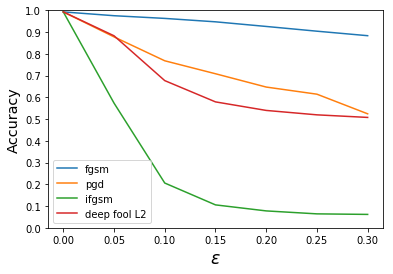

In [24]:
plt.plot(epsilons, fgsms, label = 'fgsm')
plt.plot(epsilons, pgds, label ="pgd")
plt.plot(epsilons, ifgsms, label = 'ifgsm')
plt.plot(epsilons, deepfools, label = 'deep fool L2')
plt.legend() 

plt.xlabel('$\epsilon$', size = 'xx-large', fontweight = 'demi')
plt.ylabel('Accuracy', size = 'x-large')
plt.ylim([0,1.0])
plt.yticks(np.linspace(0,1,11))
plt.savefig('figures/vafee4_1_classifier.pdf', format='pdf', bbox_inches='tight', quality = 100)
plt.show()